In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sipm.recon.WaveformAnalyzer as wfa
import sipm.recon.WaveformDataset as wfd
from scipy.optimize import curve_fit
import ROOT
import sipm.util.functions as func
from numpy.random import normal
import pandas as pd
import glob
import datetime

plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Welcome to JupyROOT 6.26/08


In [3]:
!pwd

/home/as111/sipm-analysis


In [4]:
path = "/scratch/gpfs/as111/results/"
dates = ['2023-12-14','2023-12-18','2023-12-19']
files = []
for d in dates:
    files.extend(glob.glob(f"{path}{d}/*scintillation_pulse_liq5.h5"))
print(files)
print(len(files))

['/scratch/gpfs/as111/results/2023-12-14/2023-12-14_volt_96_light_scintillation_cond_backgrounds_run4_scintillation_pulse_liq5.h5', '/scratch/gpfs/as111/results/2023-12-14/2023-12-14_volt_96_light_scintillation_cond_backgrounds_run0_scintillation_pulse_liq5.h5', '/scratch/gpfs/as111/results/2023-12-14/2023-12-14_volt_96_light_scintillation_cond_backgrounds_run1_scintillation_pulse_liq5.h5', '/scratch/gpfs/as111/results/2023-12-14/2023-12-14_volt_96_light_scintillation_cond_backgrounds_run3_scintillation_pulse_liq5.h5', '/scratch/gpfs/as111/results/2023-12-14/2023-12-14_volt_96_light_scintillation_cond_backgrounds_run2_scintillation_pulse_liq5.h5', '/scratch/gpfs/as111/results/2023-12-18/2023-12-18_volt_96_light_scintillation_cond_backgrounds_run0_scintillation_pulse_liq5.h5', '/scratch/gpfs/as111/results/2023-12-19/2023-12-19_volt_96_light_scintillation_cond_backgrounds_run5_scintillation_pulse_liq5.h5', '/scratch/gpfs/as111/results/2023-12-19/2023-12-19_volt_96_light_scintillation_con

In [5]:
# data folder
data = {}
date_time = {}
channels = np.arange(-1,8) # channel -1 contains total_pe and fprompt
volt = 96
for f in files:
    data[f] = {}
    for ch in channels:
        data[f][ch] = pd.read_hdf(f, key=f'{volt}/{ch}')
    date_time[f] = datetime.datetime(*np.array(data[f][-1]['start_datetime'][:6]).astype(int))
# sort according to date time
args = np.array(list(date_time.values())).argsort()
files = np.array(files)[args]
for f in files:
    print(f'{len(data[f][-1]["total_pe"])} events  {date_time[f]}')
print('keys (ch=-1): ', list(data[files[0]][-1].keys()))
print('keys (ch=0,1,2,3): ', list(data[files[0]][0].keys()))

49860 events  2023-12-14 14:21:02
49867 events  2023-12-14 19:38:21
49874 events  2023-12-15 00:51:26
49871 events  2023-12-15 06:03:59
49869 events  2023-12-15 11:15:52
50000 events  2023-12-18 11:56:11
49953 events  2023-12-19 10:09:44
49994 events  2023-12-19 13:20:43
49974 events  2023-12-19 16:31:57
49984 events  2023-12-19 19:42:57
49960 events  2023-12-19 22:54:09
49946 events  2023-12-20 02:05:10
49976 events  2023-12-20 05:16:10
49987 events  2023-12-20 08:27:20
49955 events  2023-12-20 11:38:18
49938 events  2023-12-20 14:49:17
50006 events  2023-12-20 18:00:31
49986 events  2023-12-20 21:11:24
49991 events  2023-12-21 00:22:17
49955 events  2023-12-21 03:33:14
49982 events  2023-12-21 06:44:04
49928 events  2023-12-21 09:54:54
keys (ch=-1):  ['start_datetime', 'end_datetime', 'duration_seconds', 'total_pe', 'fprompt']
keys (ch=0,1,2,3):  ['baseline_mean', 'baseline_rms', 'integral_0p50us', 'integral_5p00us']


## Read calibration file

In [6]:
calib = pd.read_hdf('data/calibration_liq5_2023-12-13.h5', key=f'{volt}V')
calib

,channel,A1min,A1max,DiCT,DiCT_err,Qavg,Qavg_err,Qpeak,Qpeak_err,Qap,Qap_err,bsl_rms
0,0,169.50,543.25,0.046332,0.003478,1164.728477,1.304297,1131.491681,3.416132,0.028013,0.003161,2.0
1,1,153.25,517.25,0.049100,0.001656,1144.683208,1.851095,1113.892448,1.097667,0.026285,0.001851,2.0
2,2,153.25,517.25,0.049479,0.001834,1154.966355,1.610303,1122.321809,1.350212,0.027647,0.001801,2.0
3,3,150.00,510.75,0.043612,0.005856,1150.263808,2.583902,1117.967777,2.060560,0.027628,0.002859,2.0
4,4,114.25,413.25,0.032734,0.002590,916.492212,2.721177,904.480062,2.866587,0.012846,0.004256,2.0
5,5,130.50,429.50,0.058036,0.002614,912.401287,1.673212,898.871298,1.559696,0.014179,0.002414,2.0
6,6,140.25,436.00,0.033369,0.005075,904.286389,1.489399,892.146274,1.304836,0.013154,0.002158,2.0
7,7,133.75,442.50,0.031540,0.003544,915.056285,0.928691,902.121780,0.788094,0.013886,0.001315,2.0


In [7]:
convert_pe = calib['Qpeak']*(1+calib['Qap'])/(1-calib['DiCT'])
convert_pe

0    1219.699442
1    1202.199751
2    1213.388966
3    1201.244232
4     947.101399
5     967.782168
6     935.083935
7     944.435960
dtype: float64

## Baseline cut
Same baseline cut as calibration data (baseline std $<1.9$ ADC units). Cut fraction higher.

In [8]:
# Initialize container
baseline = {}
for f in files:
    baseline[f] = {}
    for ch in channels:
        baseline[f][ch] = {}

In [9]:
# Produce baseline rms histograms
nbins = 500
range_min = 0
range_max = 10
for f in files:
    for ch in channels[1:]:
        baseline[f][ch]['rms_counts'], baseline[f][ch]['rms_bins'] = np.histogram(data[f][ch]['baseline_rms'], bins=nbins, range=(range_min, range_max))
        if ch==0:
            baseline[f][ch]['rms_threshold'] = 1.9
        elif ch==1:
            baseline[f][ch]['rms_threshold'] = 1.9
        elif ch==2:
            baseline[f][ch]['rms_threshold'] = 1.9
        elif ch==3:
            baseline[f][ch]['rms_threshold'] = 1.9
        elif ch==4:
            baseline[f][ch]['rms_threshold'] = 1.9
        elif ch==5:
            baseline[f][ch]['rms_threshold'] = 1.9
        elif ch==6:
            baseline[f][ch]['rms_threshold'] = 1.9
        elif ch==7:
            baseline[f][ch]['rms_threshold'] = 1.9

In [10]:
# Produce baseline mean histograms
nbins = 500
range_min = 3800
range_max = 4000
for f in files:
    for ch in channels[1:]:
        baseline[f][ch]['mean_counts'], baseline[f][ch]['mean_bins'] = np.histogram(
            data[f][ch]['baseline_mean'], 
            bins=nbins, range=(range_min, range_max)
        )
        baseline[f][ch]['mean_counts_cut'], baseline[f][ch]['mean_bins_cut'] = np.histogram(
            data[f][ch].loc[data[f][ch]['baseline_rms']<baseline[f][ch]['rms_threshold'],'baseline_mean'], # cut on baseline rms
            bins=nbins, range=(range_min, range_max)
        )

In [11]:
# Calculate cut fraction
data_aggr_nocut = {}
data_aggr_bslcut = {}
for f in files:
    # Compute PEs from top and bottom SiPMs
    pe_ch = pd.concat([data[f][ch]['integral_5p00us'] for ch in range(8)],axis=1)
    pe_ch.columns = np.arange(8)
    pe_ch = pe_ch/convert_pe
    top_pe, bot_pe = pe_ch.iloc[:,-4:].sum(axis=1), pe_ch.iloc[:,:4].sum(axis=1)
    # combine total_pe, fprompt, and baseline rms for each channel into a single DF
    data_aggr_nocut[f] = np.vstack((
        data[f][-1]['total_pe'],
        top_pe,
        bot_pe,
        data[f][-1]['fprompt'],
        data[f][0]['baseline_rms'],
        data[f][1]['baseline_rms'],
        data[f][2]['baseline_rms'],
        data[f][3]['baseline_rms'],
        data[f][4]['baseline_rms'],
        data[f][5]['baseline_rms'],
        data[f][6]['baseline_rms'],
        data[f][7]['baseline_rms']
    )).T
    for ch in channels:
        data[f][ch] = None # clear memory
    data_aggr_nocut[f] = pd.DataFrame(
        data_aggr_nocut[f],
        columns=['total_pe','top_pe','bot_pe','fprompt','baseline_rms0','baseline_rms1','baseline_rms2','baseline_rms3','baseline_rms4','baseline_rms5','baseline_rms6','baseline_rms7']
    )
    # apply baseline cut on all channels
    data_aggr_bslcut[f] = data_aggr_nocut[f].loc[ 
        (data_aggr_nocut[f]['baseline_rms0']<baseline[f][0]['rms_threshold']) & 
        (data_aggr_nocut[f]['baseline_rms1']<baseline[f][1]['rms_threshold']) & 
        (data_aggr_nocut[f]['baseline_rms2']<baseline[f][2]['rms_threshold']) & 
        (data_aggr_nocut[f]['baseline_rms3']<baseline[f][3]['rms_threshold']) &
        (data_aggr_nocut[f]['baseline_rms4']<baseline[f][4]['rms_threshold']) & 
        (data_aggr_nocut[f]['baseline_rms5']<baseline[f][5]['rms_threshold']) & 
        (data_aggr_nocut[f]['baseline_rms6']<baseline[f][6]['rms_threshold']) & 
        (data_aggr_nocut[f]['baseline_rms7']<baseline[f][7]['rms_threshold'])
    ]
    cut_fraction = 1-data_aggr_bslcut[f].shape[0]/data_aggr_nocut[f].shape[0]
    data_aggr_nocut[f] = None # clear memory
    baseline[f][-1]['cut_fraction'] = cut_fraction
    print(f'{date_time[f]} {volt}V cut fraction = {cut_fraction*100:.5f}%')
# clear memory
data = None
data_aggr_nocut = None

2023-12-14 14:21:02 96V cut fraction = 4.28199%
2023-12-14 19:38:21 96V cut fraction = 5.68913%
2023-12-15 00:51:26 96V cut fraction = 4.35297%
2023-12-15 06:03:59 96V cut fraction = 4.60588%
2023-12-15 11:15:52 96V cut fraction = 4.54792%
2023-12-18 11:56:11 96V cut fraction = 6.65400%
2023-12-19 10:09:44 96V cut fraction = 6.82842%
2023-12-19 13:20:43 96V cut fraction = 6.85482%
2023-12-19 16:31:57 96V cut fraction = 6.77953%
2023-12-19 19:42:57 96V cut fraction = 6.96223%
2023-12-19 22:54:09 96V cut fraction = 6.82546%
2023-12-20 02:05:10 96V cut fraction = 7.04361%
2023-12-20 05:16:10 96V cut fraction = 7.08740%
2023-12-20 08:27:20 96V cut fraction = 7.07584%
2023-12-20 11:38:18 96V cut fraction = 6.89821%
2023-12-20 14:49:17 96V cut fraction = 7.00669%
2023-12-20 18:00:31 96V cut fraction = 6.93317%
2023-12-20 21:11:24 96V cut fraction = 6.98596%
2023-12-21 00:22:17 96V cut fraction = 6.87324%
2023-12-21 03:33:14 96V cut fraction = 6.96827%
2023-12-21 06:44:04 96V cut fraction = 7

In [12]:
# Print container keys
print('baseline keys: ', list(
    baseline[files[0]][0].keys()))

baseline keys:  ['rms_counts', 'rms_bins', 'rms_threshold', 'mean_counts', 'mean_bins', 'mean_counts_cut', 'mean_bins_cut']


Text(0.07, 0.5, 'Count')

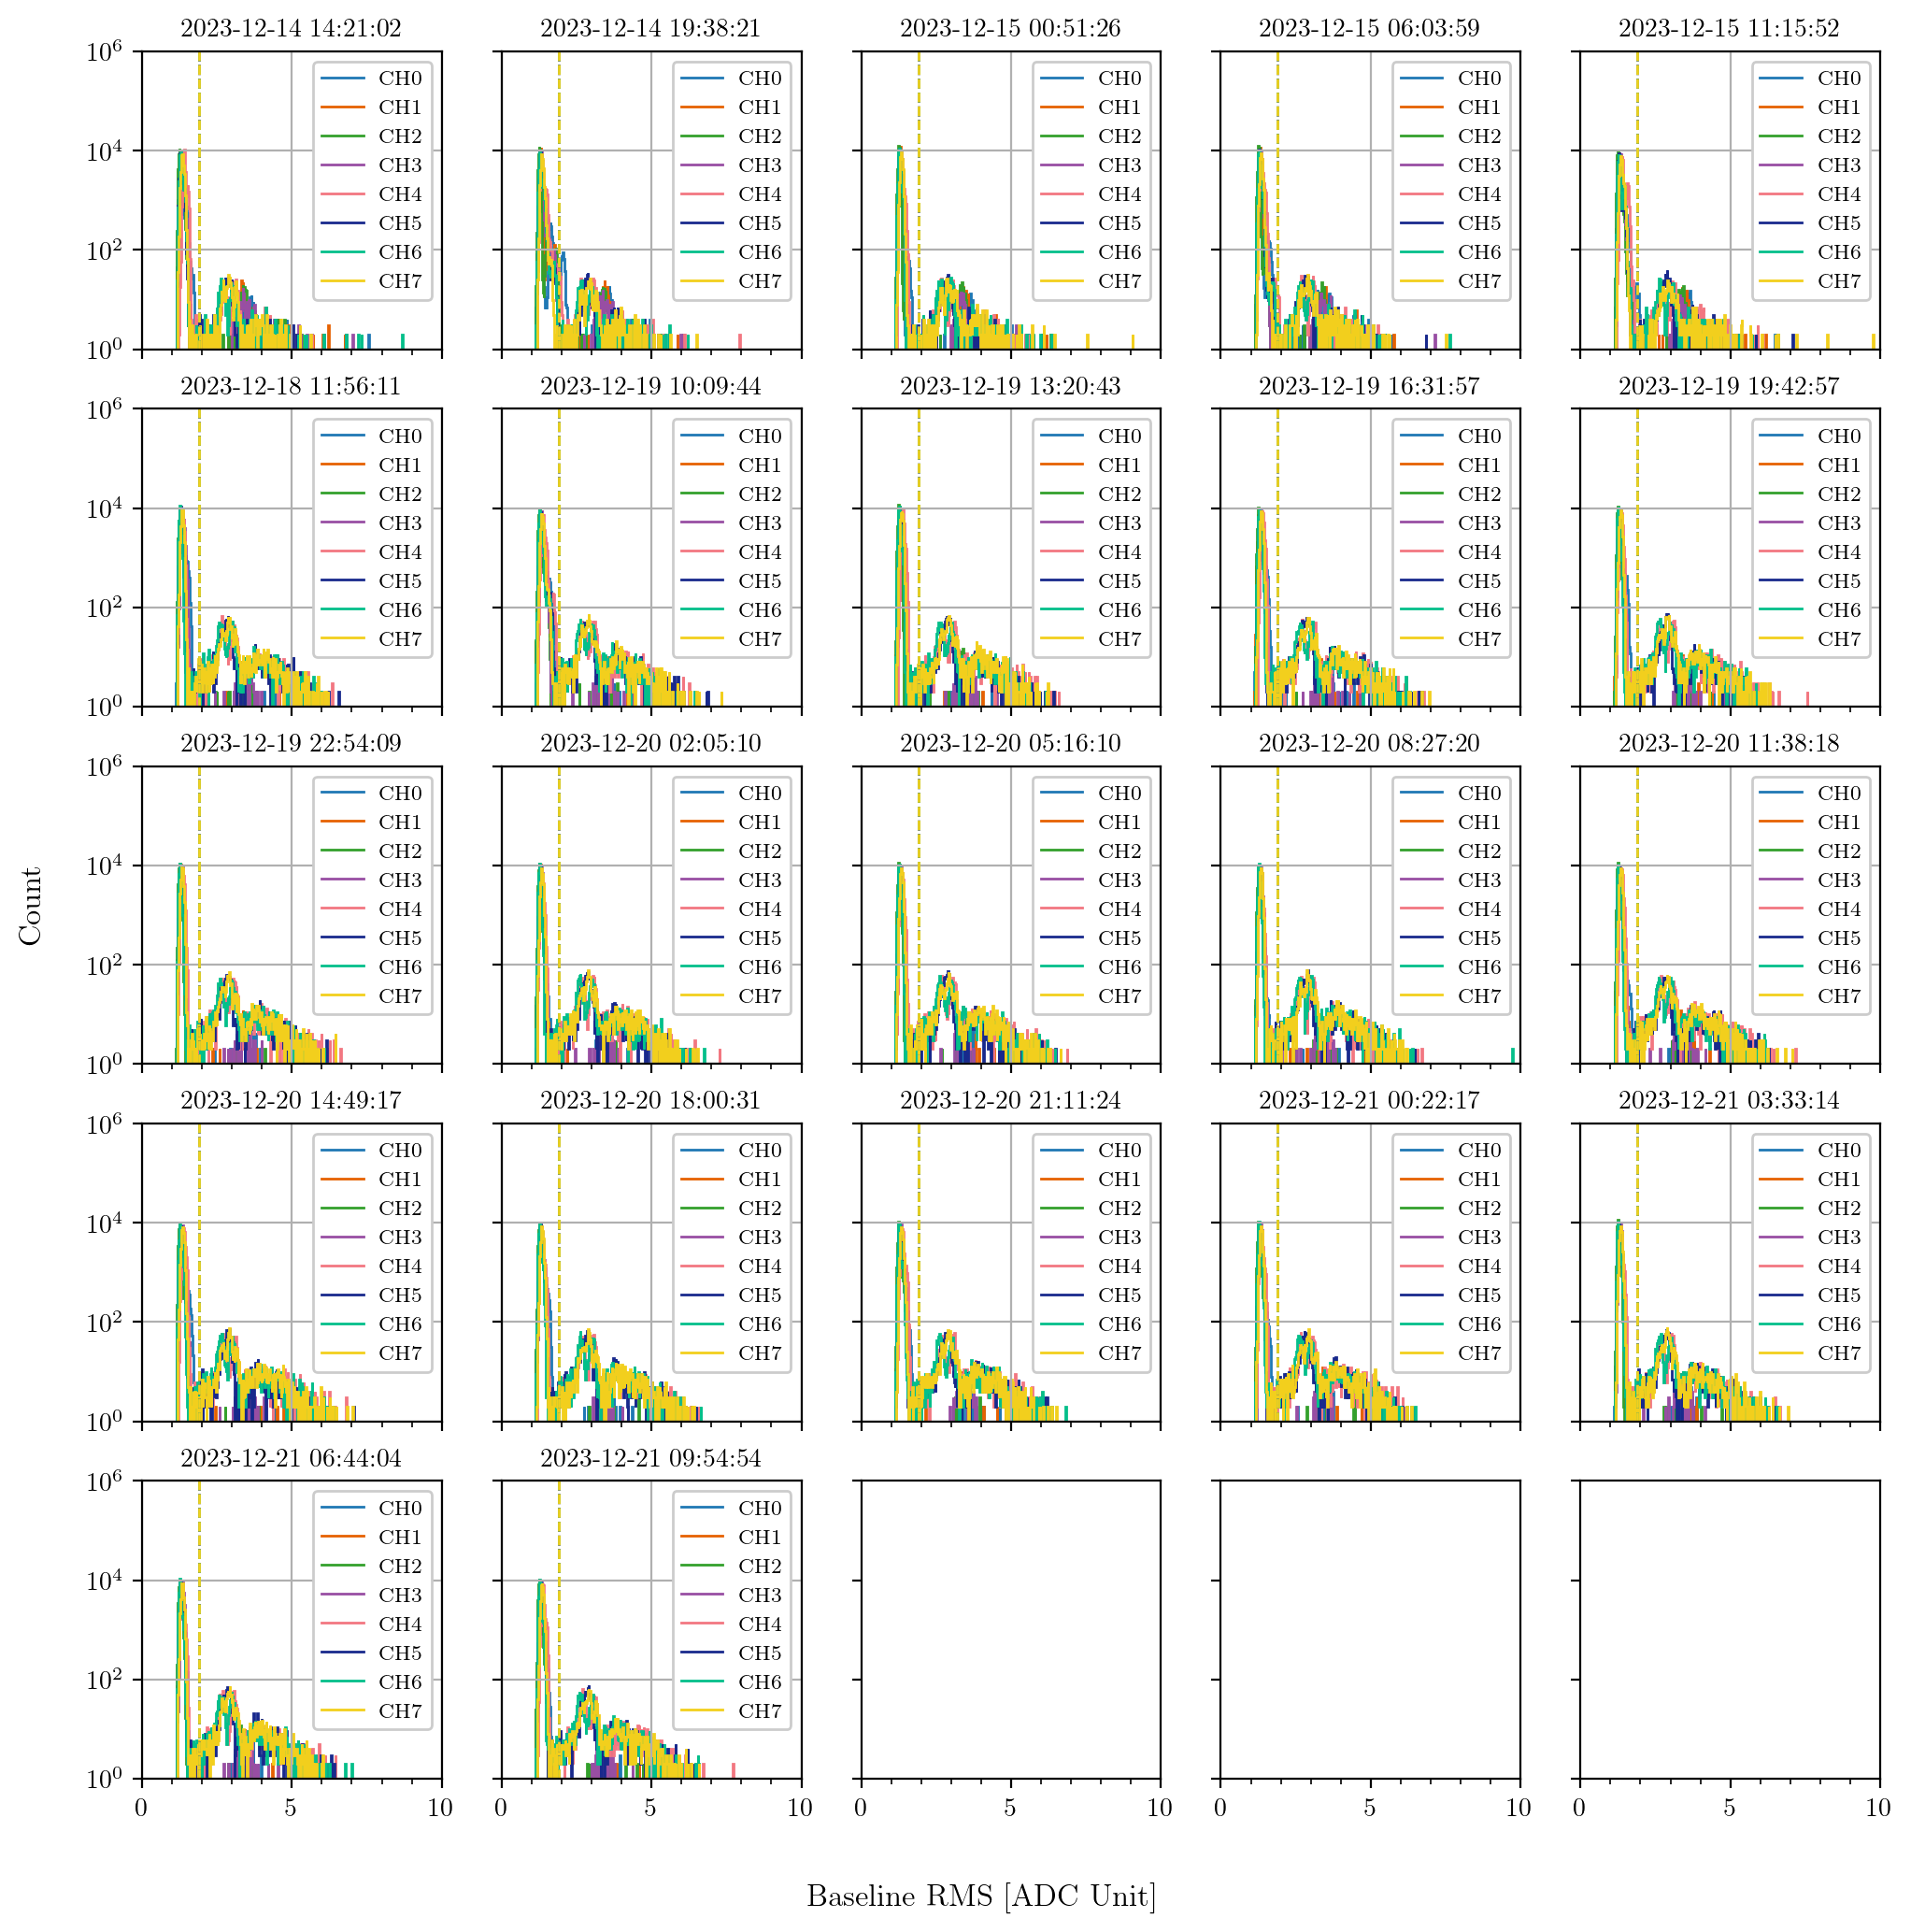

In [13]:
# Make plots for all datasets
# Baseline RMS
fig, axs = plt.subplots(5, 5, sharex=True, sharey=True)
fig.set_size_inches(12, 12)
for i, f in enumerate(files):
    for k, ch in enumerate(channels[1:]):
        axs[i//5,i%5].stairs(
            baseline[f][ch]['rms_counts'],
            baseline[f][ch]['rms_bins'],
            label=f'CH{ch}', color=f'C{k}'
        )
        th = baseline[f][ch]['rms_threshold']
        axs[i//5,i%5].plot([th, th], [1, 1e6], f'C{k}--', linewidth=1)
    axs[i//5,i%5].legend(loc='upper right')
    axs[i//5,i%5].set_ylim(1, 1e6)
    axs[i//5,i%5].set_yscale('log')
    axs[i//5,i%5].minorticks_on()
    axs[i//5,i%5].grid()
    axs[i//5,i%5].set_title(f'{date_time[f]}')
fig.supxlabel('Baseline RMS [ADC Unit]', y=0.05)
fig.supylabel('Count', x=0.07)

Text(0.07, 0.5, 'Count')

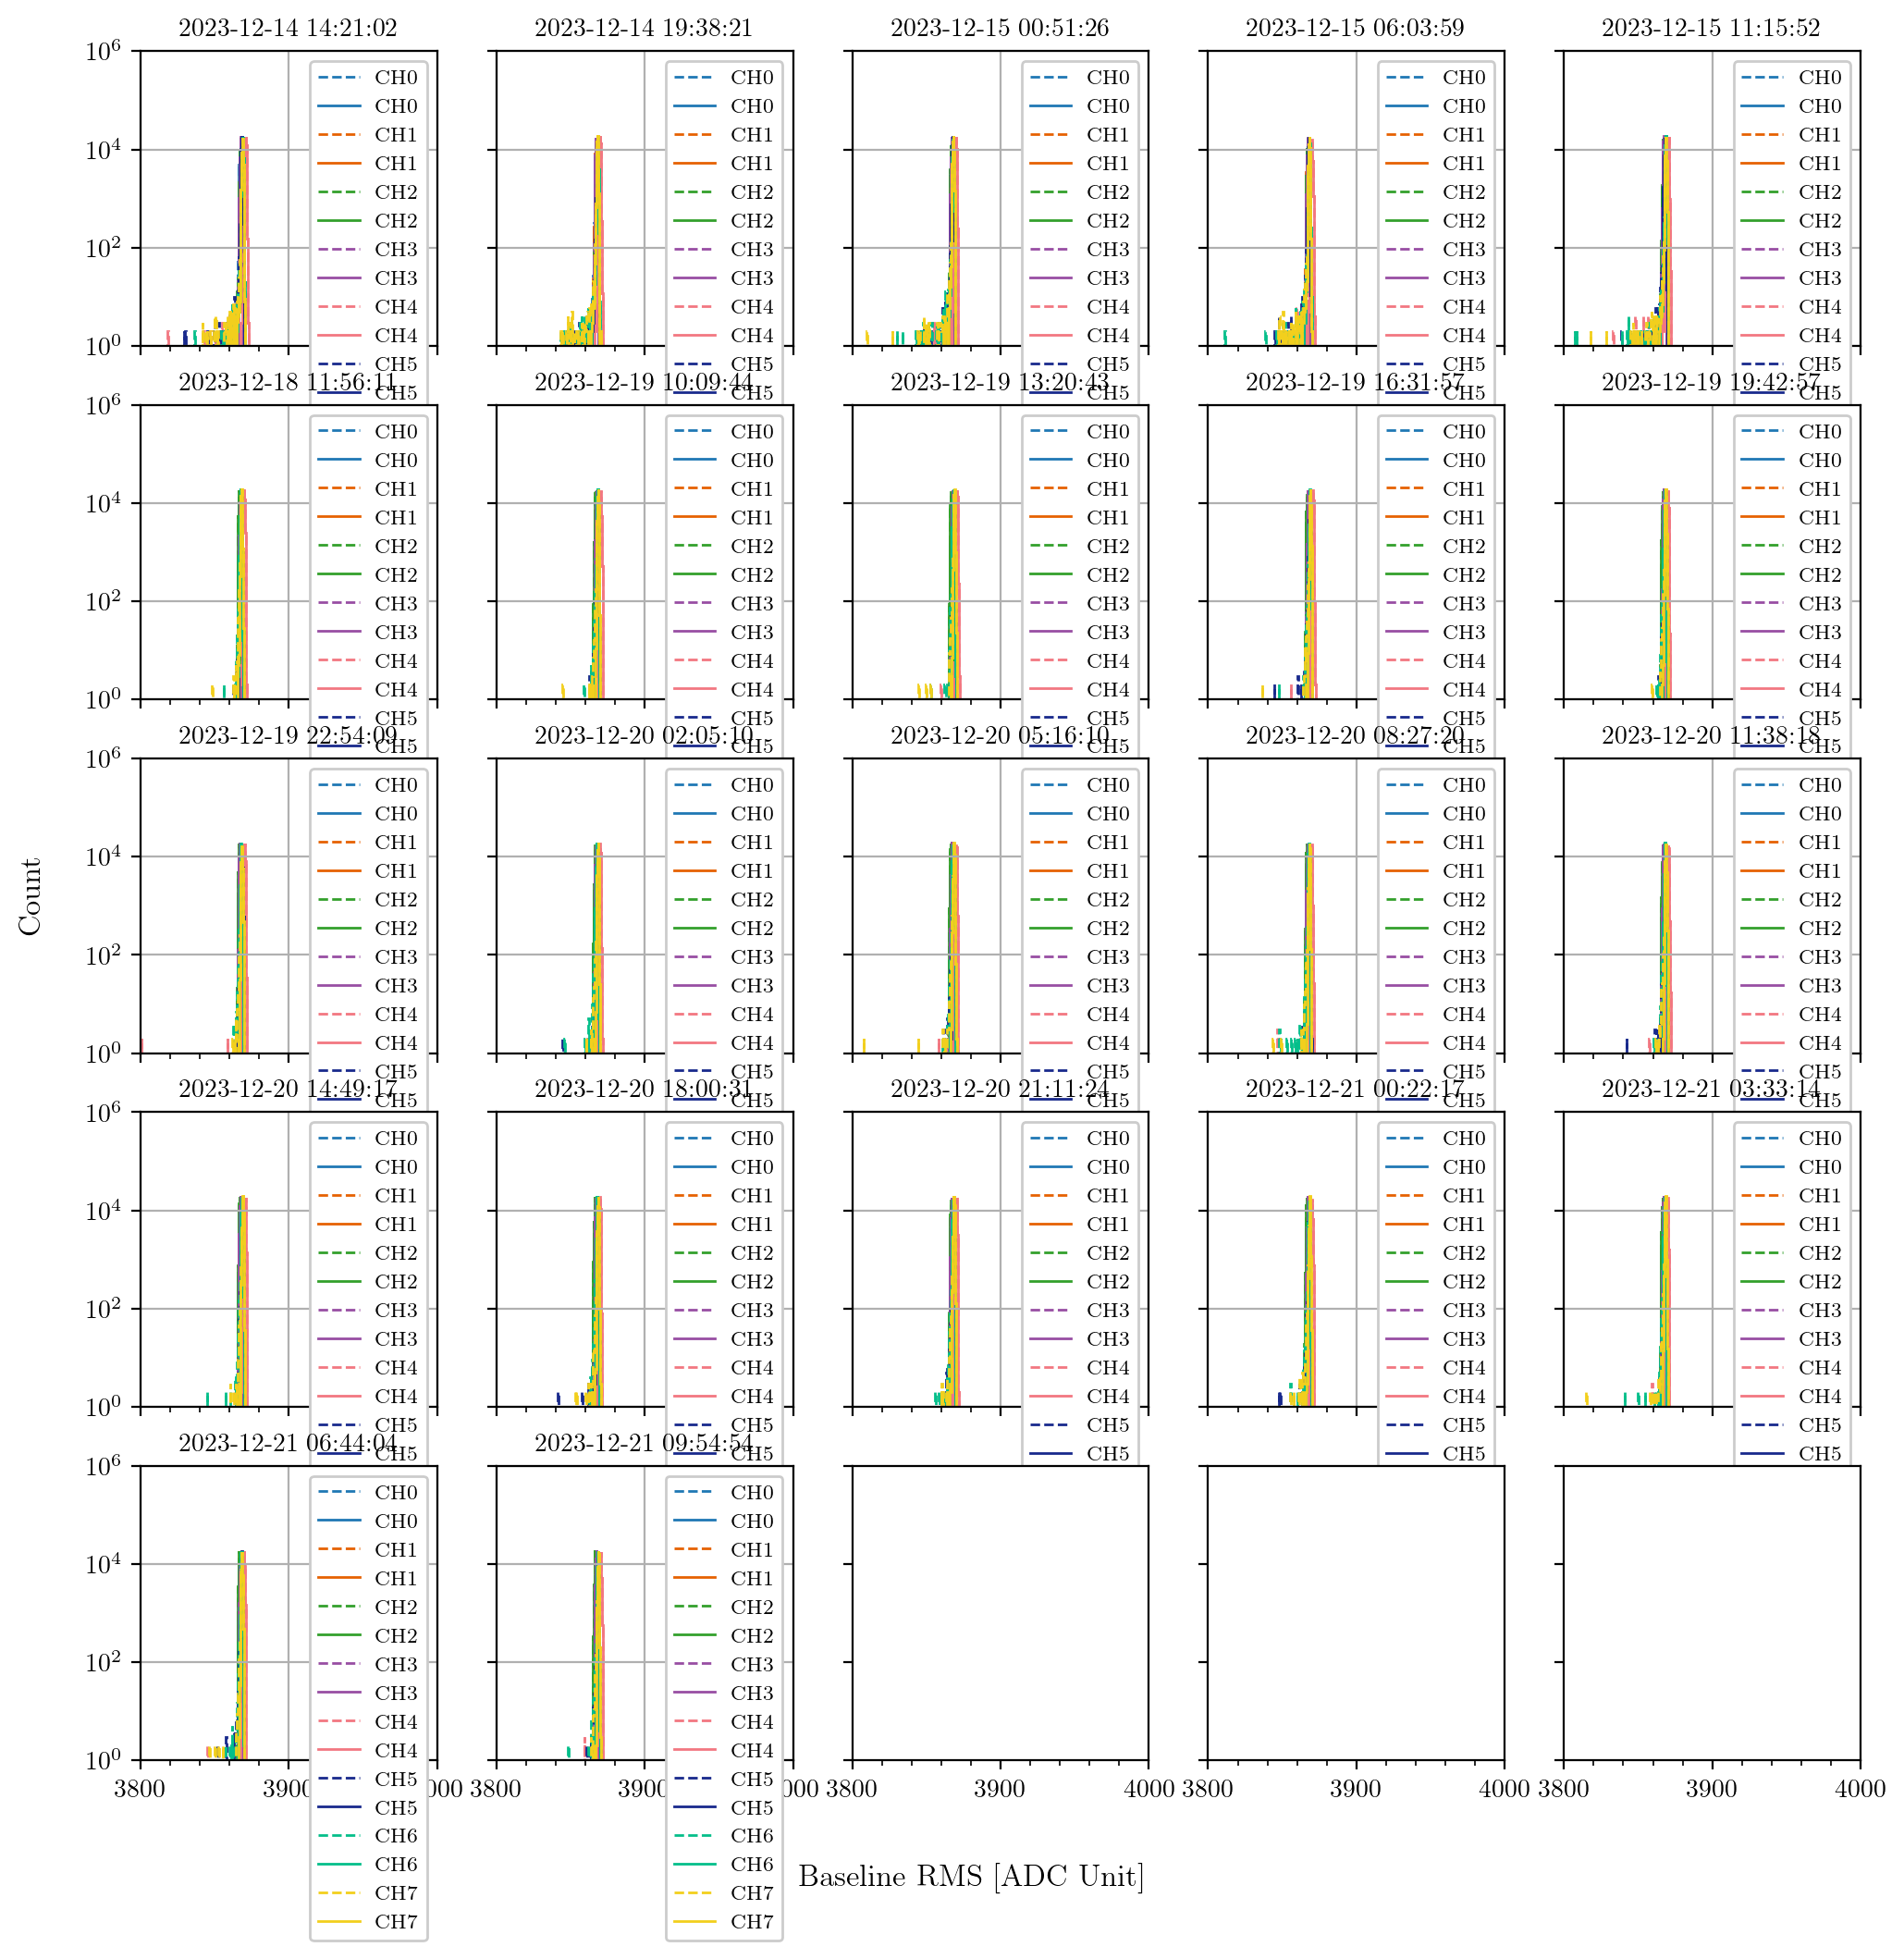

In [14]:
# Make plots for all datasets
# Baseline mean
fig, axs = plt.subplots(5, 5, sharex=True, sharey=True)
fig.set_size_inches(12, 12)
for i, f in enumerate(files):
    for k, ch in enumerate(channels[1:]):
        axs[i//5,i%5].stairs(
            baseline[f][ch]['mean_counts'],
            baseline[f][ch]['mean_bins'],
            label=f'CH{ch}', color=f'C{k}', linestyle='--'
        )
        axs[i//5,i%5].stairs(
            baseline[f][ch]['mean_counts_cut'],
            baseline[f][ch]['mean_bins_cut'],
            label=f'CH{ch}', color=f'C{k}'
        )
    axs[i//5,i%5].legend(loc='upper right')
    axs[i//5,i%5].set_ylim(1, 1e6)
    axs[i//5,i%5].set_yscale('log')
    axs[i//5,i%5].minorticks_on()
    axs[i//5,i%5].grid()
    axs[i//5,i%5].set_title(f'{date_time[f]}')
fig.supxlabel('Baseline RMS [ADC Unit]', y=0.05)
fig.supylabel('Count', x=0.07)

Plots for 2023-12-14 14:21:02 ch0


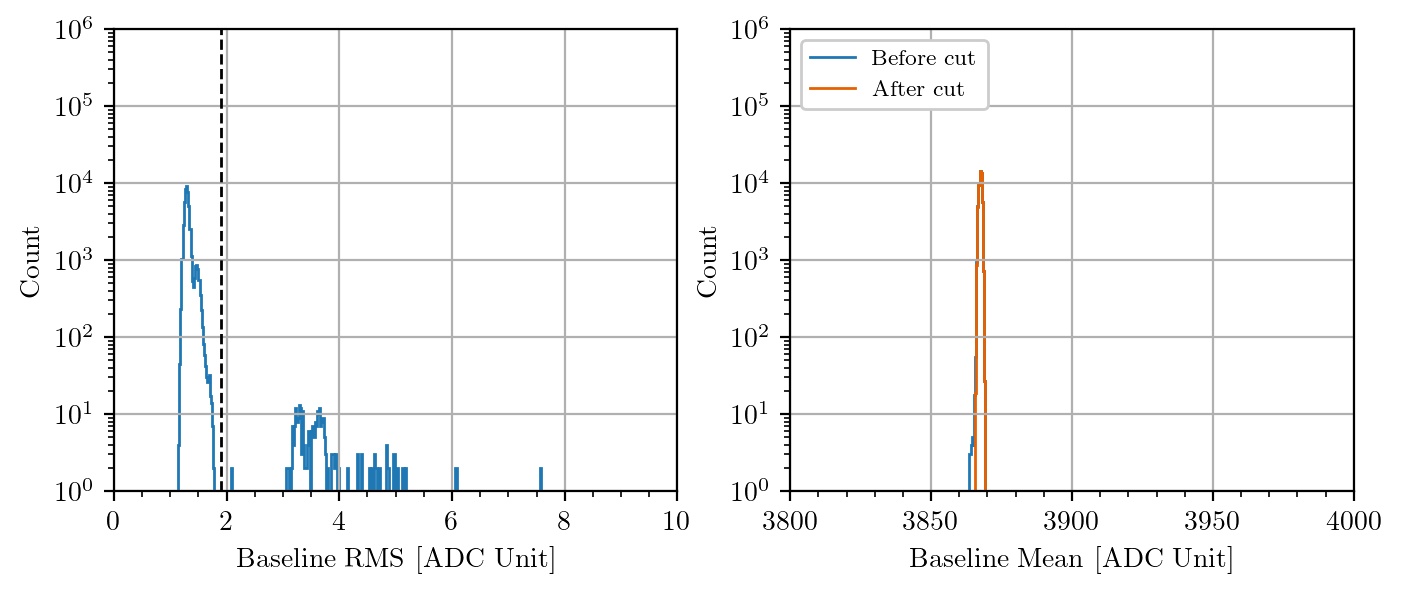

In [15]:
# Make plots for selected dataset
f = files[0]
ch = 0
print(f'Plots for {date_time[f]} ch{ch}')
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 3)

# rms
axs[0].stairs(baseline[f][ch]['rms_counts'],
              baseline[f][ch]['rms_bins'])
th = baseline[f][ch]['rms_threshold']
axs[0].plot([th, th], [1, 1e6], 'k--', linewidth=1)
axs[0].set_ylim(1, 1e6)
axs[0].set_yscale('log')
axs[0].set_xlabel('Baseline RMS [ADC Unit]')
axs[0].set_ylabel('Count')
axs[0].minorticks_on()
axs[0].grid()

# mean
axs[1].stairs(baseline[f][ch]['mean_counts'],
              baseline[f][ch]['mean_bins'],
              label='Before cut')
axs[1].stairs(baseline[f][ch]['mean_counts_cut'],
              baseline[f][ch]['mean_bins_cut'],
              label='After cut')
axs[1].legend()
axs[1].set_yscale('log')
axs[1].set_ylim(1, 1e6)
axs[1].set_xlim(3800, 4000)
axs[1].set_xlabel('Baseline Mean [ADC Unit]')
axs[1].set_ylabel('Count')
axs[1].minorticks_on()
axs[1].grid()

## Fprompt cut
$F_{\rm prompt}$ is defined as the prompt ($0.5~\rm \mu s$) integral divided by the full ($5~\rm \mu s$) integral.
The ER band of $F_{\rm prompt}\sim0.3$ is clearly visible.
Yet some events have $F_{\rm prompt}\simeq0$, likely due to events triggered on noise with a delayed scintillation pulse.
These are rejected by requiring $F_{\rm prompt}>0.1$.

In [16]:
# Initialize container
fprompt = {}
for f in files:
    fprompt[f] = {}

In [17]:
# Produce fprompt 2D histograms
nbinsx = 600
range_minx = -10
range_maxx = 300
nbinsy = 600
range_miny = -0.1
range_maxy = 1

for f in files:
    fprompt[f]['fp_counts'], fprompt[f]['fp_xbins'], fprompt[f]['fp_ybins'] = np.histogram2d(
        data_aggr_bslcut[f]['total_pe'], 
        data_aggr_bslcut[f]['fprompt'], 
        bins=[nbinsx,nbinsy], range=[[range_minx,range_maxx],[range_miny,range_maxy]]
    )
    fprompt[f]['fp_counts'] = fprompt[f]['fp_counts'].T
    fprompt[f]['fp_xbins'], fprompt[f]['fp_ybins'] = np.meshgrid(
        fprompt[f]['fp_xbins'], fprompt[f]['fp_ybins']
    )
    fprompt[f]['fp_threshold'] = 0.1

Text(0.07, 0.5, '$F_{\\rm prompt}$')

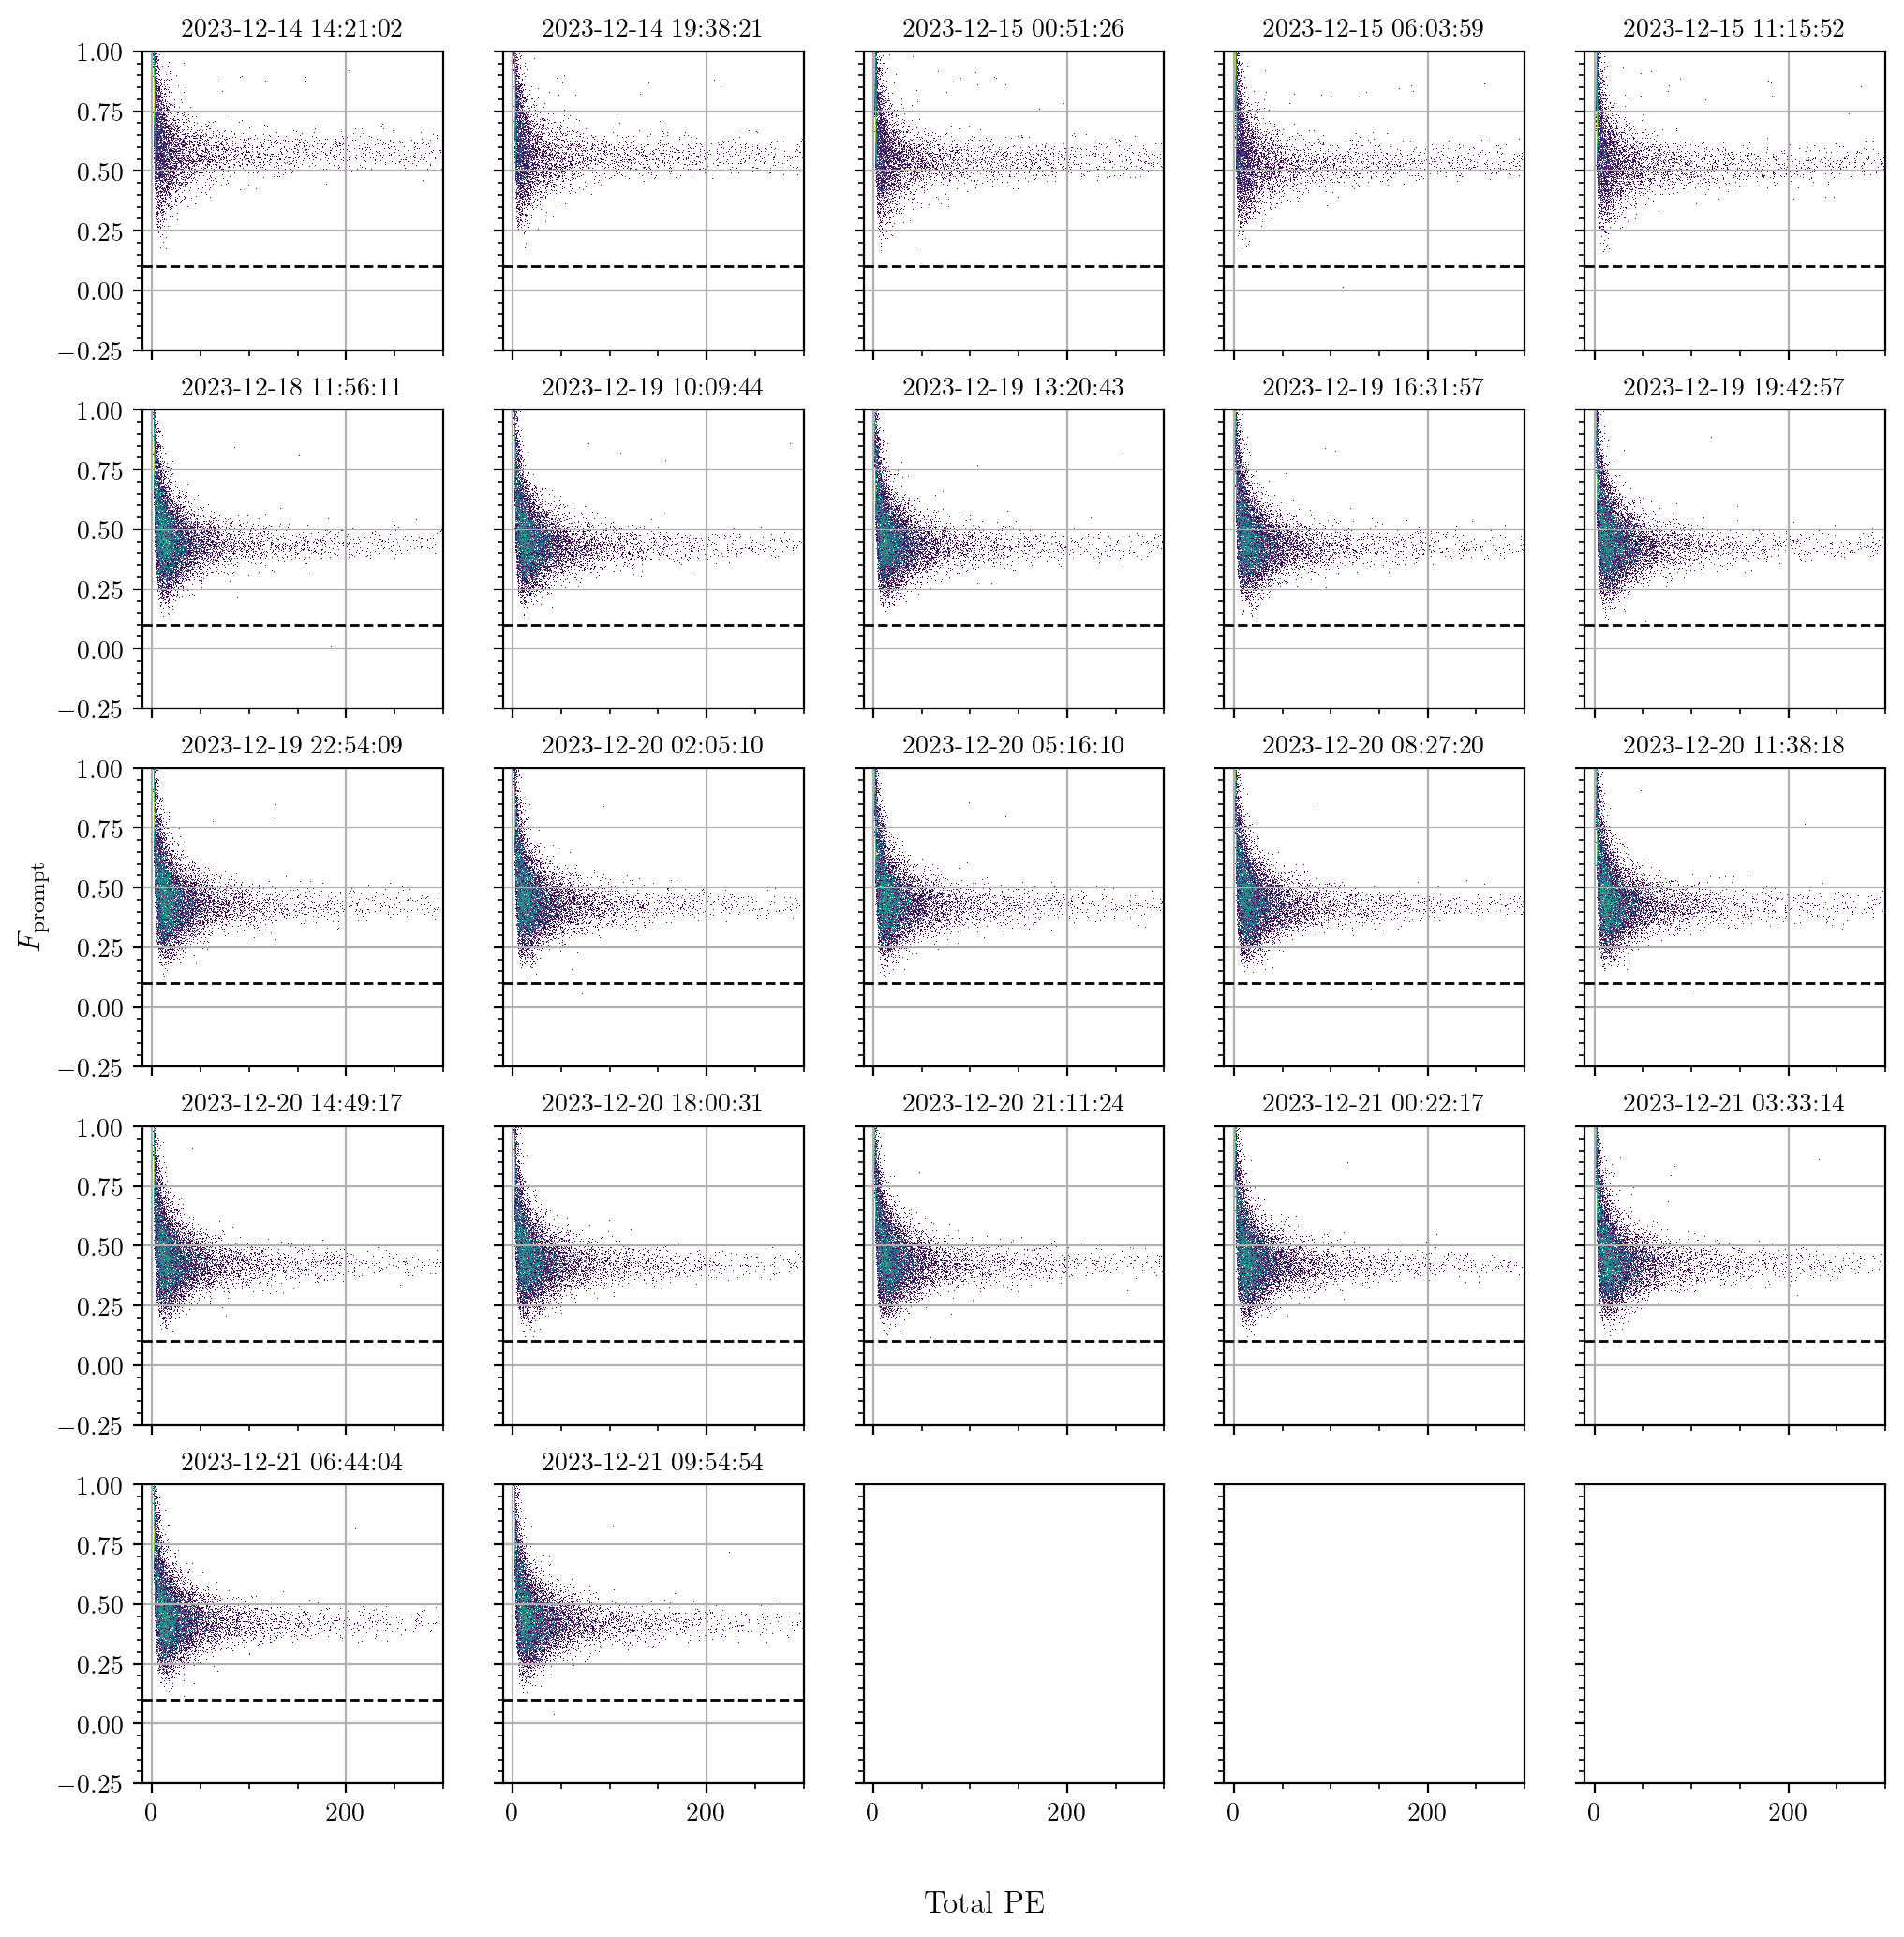

In [18]:
# Make plots for all datasets
# Fprompt
fig, axs = plt.subplots(5, 5, sharex=True, sharey=True)
fig.set_size_inches(12, 12)
for i, f in enumerate(files):
    axs[i//5,i%5].pcolormesh(
        fprompt[f]['fp_xbins'],
        fprompt[f]['fp_ybins'],
        np.log10(fprompt[f]['fp_counts'])
    )
    th = fprompt[f]['fp_threshold']
    axs[i//5,i%5].plot([-10, range_maxx], [th, th], f'k--', linewidth=1)
    axs[i//5,i%5].set_xlim(-10, range_maxx)
    axs[i//5,i%5].minorticks_on()
    axs[i//5,i%5].grid()
    axs[i//5,i%5].set_title(f'{date_time[f]}')
fig.supxlabel('Total PE', y=0.05)
fig.supylabel(r'$F_{\rm prompt}$', x=0.07)

Plots for 2023-12-20 14:49:17 ch0


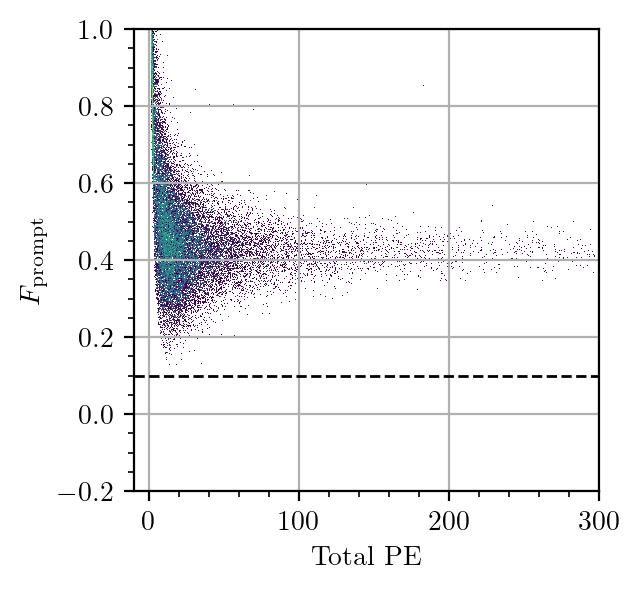

In [19]:
# Make plots for selected dataset
f = files[15]
ch = 0
print(f'Plots for {date_time[f]} ch{ch}')
fig, axs = plt.subplots(1, 1)
fig.set_size_inches(3, 3)

# Fprompt
axs.pcolormesh(fprompt[f]['fp_xbins'],fprompt[f]['fp_ybins'],np.log10(fprompt[f]['fp_counts']))
th = fprompt[f]['fp_threshold']
axs.plot([-10, range_maxx], [th, th], f'k--', linewidth=1)
axs.set_xlim(-10, range_maxx)
axs.set_xlabel('Total PE')
axs.set_ylabel(r'$F_{\rm prompt}$')
axs.minorticks_on()
axs.grid()

In [20]:
# Calculate cut fraction: fprompt>0.1
data_aggr_allcuts = {}
for f in files:  
    data_aggr_allcuts[f] = data_aggr_bslcut[f].loc[ 
        data_aggr_bslcut[f]['fprompt']>fprompt[f]['fp_threshold'] 
    ]
    cut_fraction = 1-data_aggr_allcuts[f].shape[0]/data_aggr_bslcut[f].shape[0]
    fprompt[f]['cut_fraction'] = cut_fraction
    print(f'{date_time[f]} cut fraction = {cut_fraction*100:.5f}%')
# clear memory
data_aggr_bslcut = None

2023-12-14 14:21:02 cut fraction = 0.15506%
2023-12-14 19:38:21 cut fraction = 0.14884%
2023-12-15 00:51:26 cut fraction = 0.18028%
2023-12-15 06:03:59 cut fraction = 0.19338%
2023-12-15 11:15:52 cut fraction = 0.13025%
2023-12-18 11:56:11 cut fraction = 0.04499%
2023-12-19 10:09:44 cut fraction = 0.04082%
2023-12-19 13:20:43 cut fraction = 0.05583%
2023-12-19 16:31:57 cut fraction = 0.04937%
2023-12-19 19:42:57 cut fraction = 0.05376%
2023-12-19 22:54:09 cut fraction = 0.04082%
2023-12-20 02:05:10 cut fraction = 0.05385%
2023-12-20 05:16:10 cut fraction = 0.04953%
2023-12-20 08:27:20 cut fraction = 0.04521%
2023-12-20 11:38:18 cut fraction = 0.06235%
2023-12-20 14:49:17 cut fraction = 0.03876%
2023-12-20 18:00:31 cut fraction = 0.03868%
2023-12-20 21:11:24 cut fraction = 0.03226%
2023-12-21 00:22:17 cut fraction = 0.03222%
2023-12-21 03:33:14 cut fraction = 0.04519%
2023-12-21 06:44:04 cut fraction = 0.05166%
2023-12-21 09:54:54 cut fraction = 0.03019%


In [21]:
# Print container keys
print('fprompt keys: ', list(
    fprompt[files[0]].keys()))
print('data_aggr_allcuts keys: ', list(
    data_aggr_allcuts[files[0]].keys()))

fprompt keys:  ['fp_counts', 'fp_xbins', 'fp_ybins', 'fp_threshold', 'cut_fraction']
data_aggr_allcuts keys:  ['total_pe', 'top_pe', 'bot_pe', 'fprompt', 'baseline_rms0', 'baseline_rms1', 'baseline_rms2', 'baseline_rms3', 'baseline_rms4', 'baseline_rms5', 'baseline_rms6', 'baseline_rms7']


## Draw spectra
The PE count $N_{\rm PE}$ is reconstructed as
$$N_{\rm PE}=\frac{I}{Q_{\rm peak}(1+Q_{\rm AP})/(1-p)}$$
where $I$ is the time integral ($5~\rm\mu s$) of the unfiltered waveform.
Ideally, this corrects for the direct crosstalk and afterpulsing effects of increasing light yield.

The spectra with source are subtracted by that without source (backgrounds only).
The spectra are normalized with the background sideband ($N_{\rm PE}>170$ for top and $N_{\rm PE}>900$ for bottom).

In [22]:
# Initialize container
spectra = {}
window = ['yes', 'no']
for f in files:
    spectra[f] = {}
    for w in window:
        spectra[f][w] = {}

In [43]:
# Region above norm_bounds is background only. Use event count in this region to normalize spectrum.
# norm_bounds = {'top':[2500],'bottom':[2000]}
for f in files:
    for w in window:
        if w=='yes':
            range_min = -10
            range_max = 5000
            nbins = 1000
        elif w=='no':
            range_min = -10
            range_max = 5000
            nbins = 1000
        # spectra[f][w]['norm_bound'] = norm_bounds[pos][i]
        spectra[f][w]['counts'], spectra[f][w]['bins'] = np.histogram(
            data_aggr_allcuts[f]['top_pe'] if w=='no' else data_aggr_allcuts[f]['bot_pe'], 
            bins=nbins, range=(range_min, range_max)
        )
        spectra[f][w]['errs'] = np.sqrt(spectra[f][w]['counts'])
        # normalization
        # spectra[f][w]['norm'] = np.sum(
        #     spectra[f][w]['counts'][
        #         spectra[f][w]['bins'][:-1]>spectra[f][w]['norm_bound']
        #     ]
        # )
        spectra[f][w]['norm'] = 1

# Backgrounds and Cs-137 Data

Text(0.07, 0.5, 'Count')

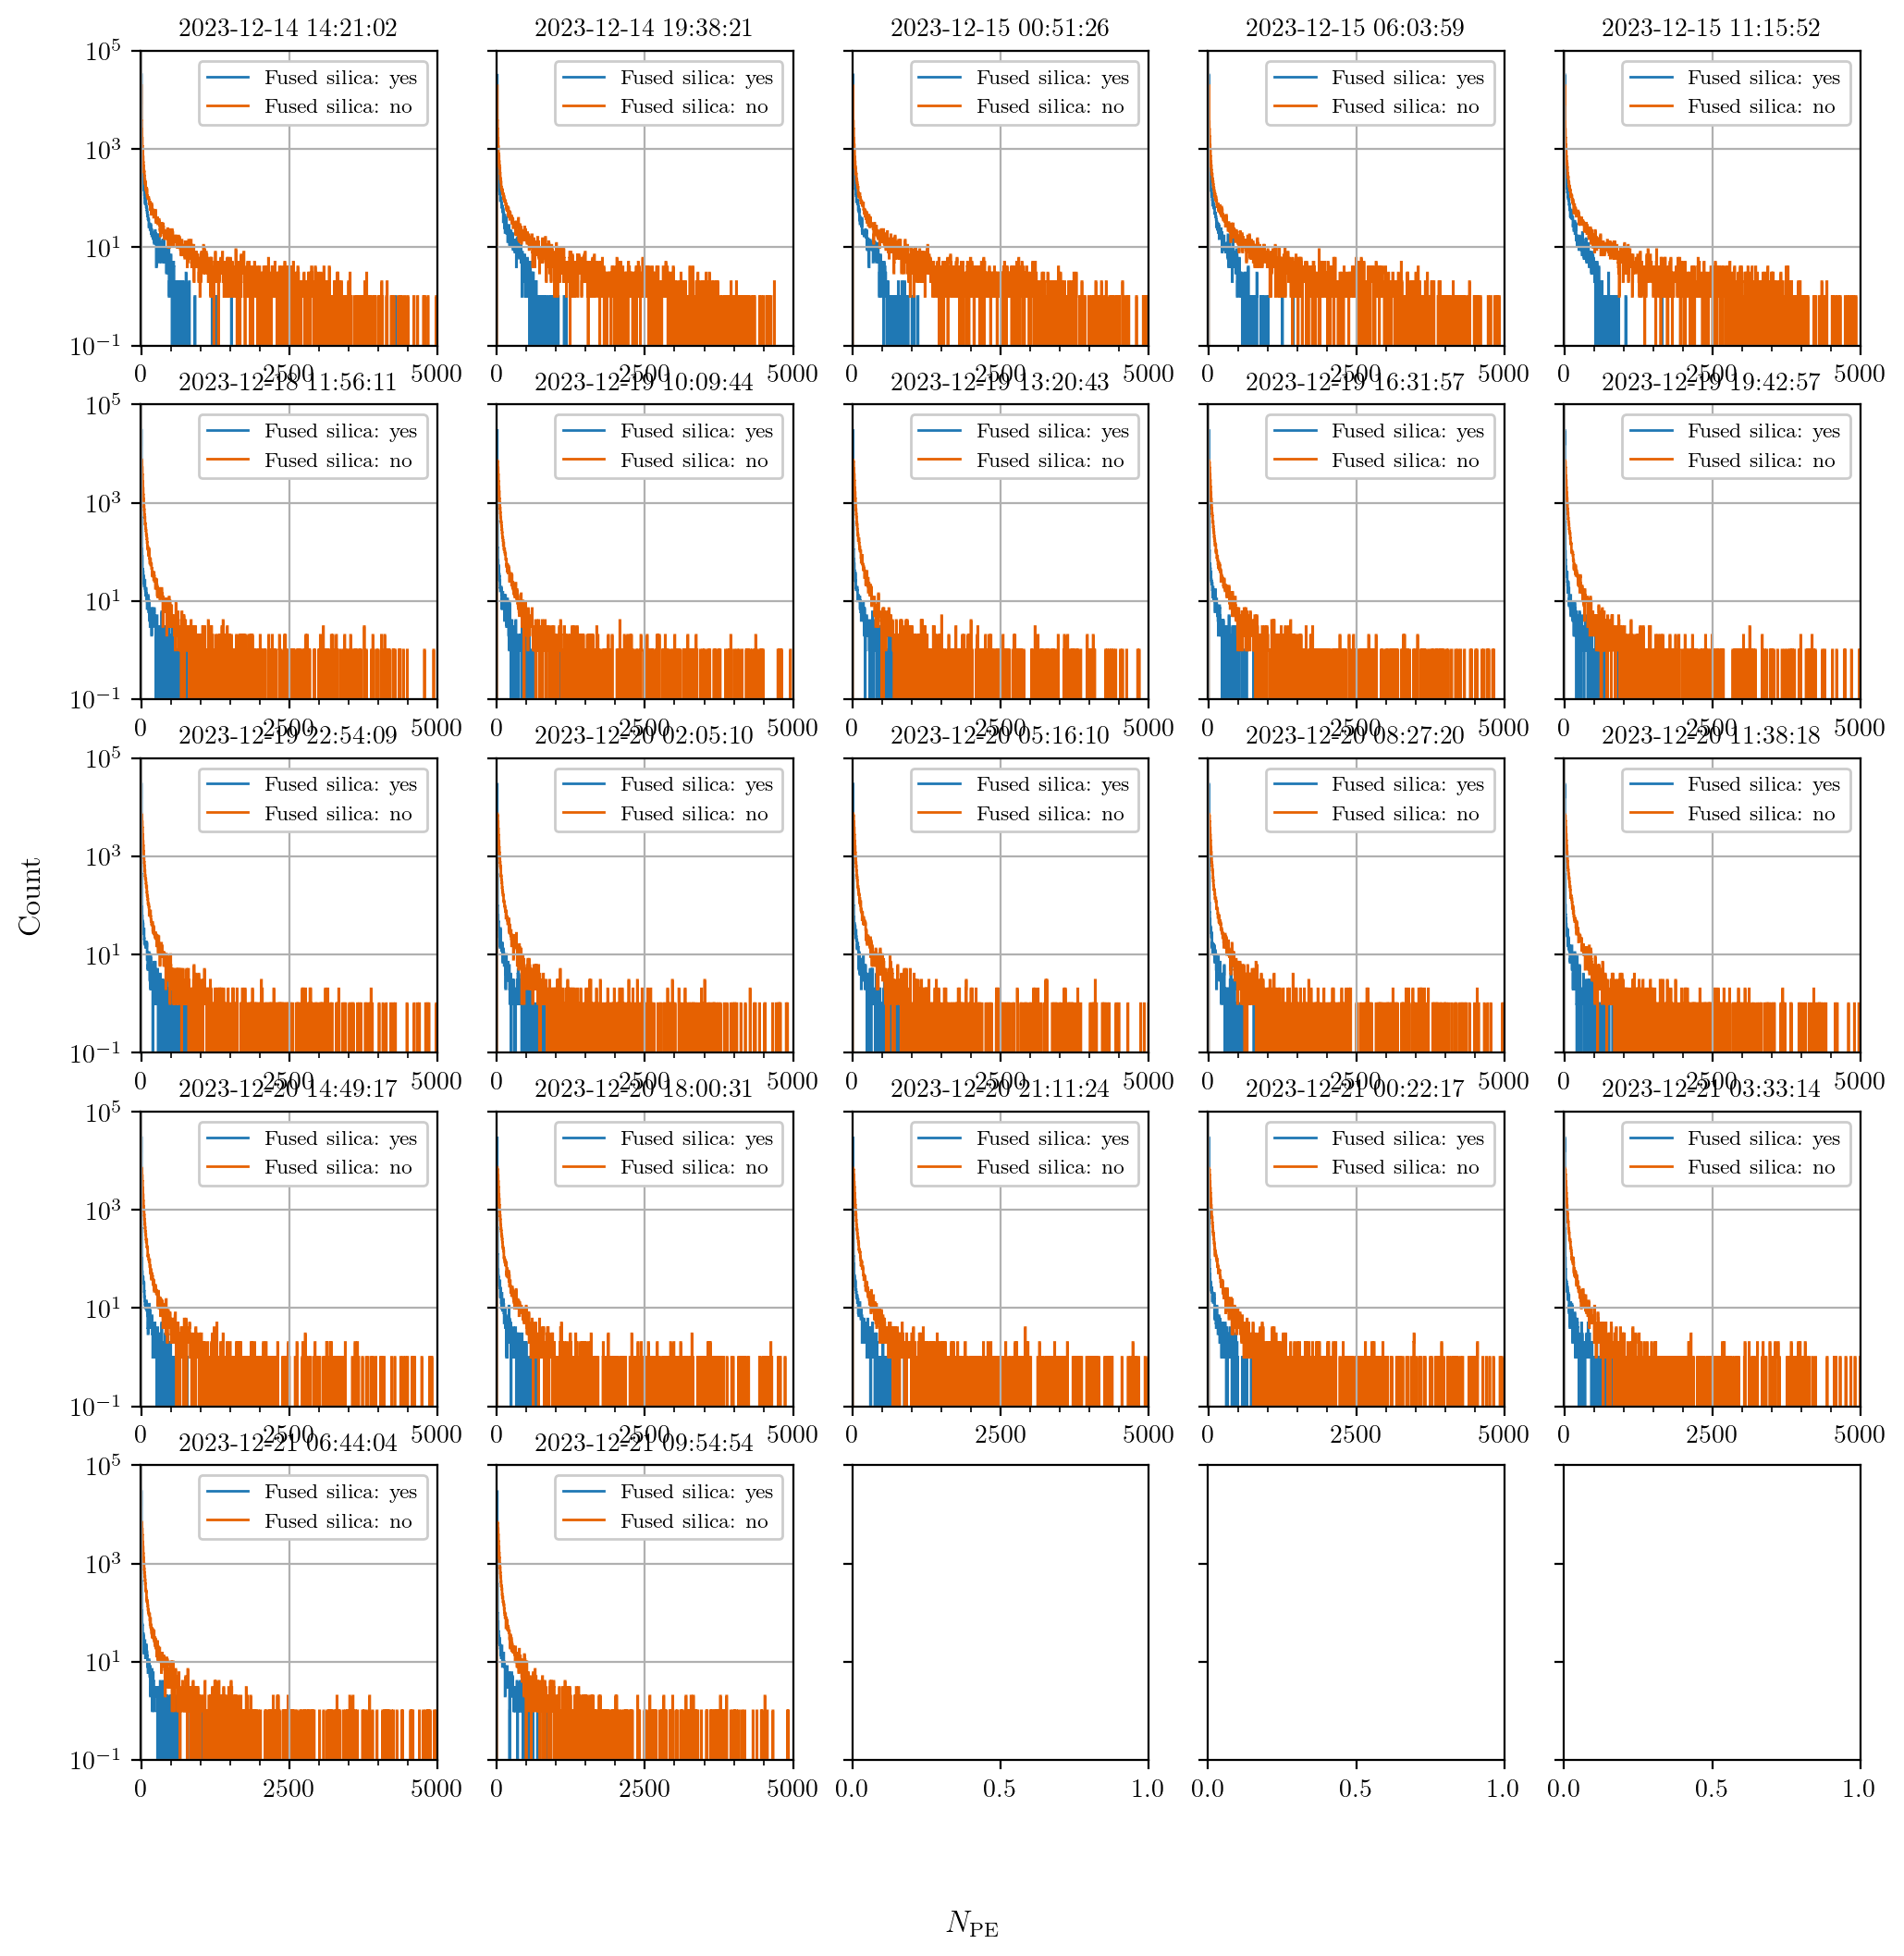

In [45]:
# Make plots for all datasets
# With source, without source, and background subtracted
fig, axs = plt.subplots(5, 5, sharex=False, sharey=True)
fig.set_size_inches(12, 12)
for i, f in enumerate(files):
    for j, w in enumerate(window):
        axs[i//5,i%5].stairs(
            spectra[f][w]['counts']/spectra[f][w]['norm'],
            spectra[f][w]['bins'],
            label=f'Fused silica: {w}', color=f'C{j}'
        )
    axs[i//5,i%5].legend(loc='upper right')
    axs[i//5,i%5].set_ylim(1e-1, 1e5)
    # axs[i//5,i%5].set_xlim(spectra[f][w]['bins'][0],spectra[f][w]['bins'][-1])
    axs[i//5,i%5].set_xlim(-10,5000)
    axs[i//5,i%5].set_yscale('log')
    axs[i//5,i%5].minorticks_on()
    axs[i//5,i%5].grid()
    axs[i//5,i%5].set_title(f'{date_time[f]}')
fig.supxlabel(r'$N_{\rm PE}$', y=0.03)
fig.supylabel('Count', x=0.07)

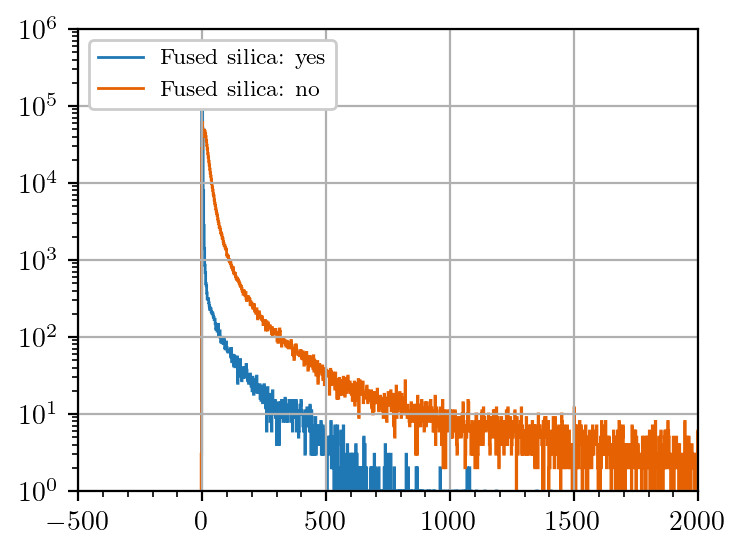

In [40]:
plt.stairs(
            np.stack([spectra[f]['yes']['counts'] for f in files[5:]], axis=1).sum(axis=1),
            spectra[files[0]]['yes']['bins'],
            label=f'Fused silica: yes', color=f'C0'
        )
plt.stairs(
            np.stack([spectra[f]['no']['counts'] for f in files[5:]], axis=1).sum(axis=1),
            spectra[files[0]]['no']['bins'],
            label=f'Fused silica: no', color=f'C1'
        )
plt.legend()
plt.yscale('log')
plt.grid()
plt.minorticks_on()


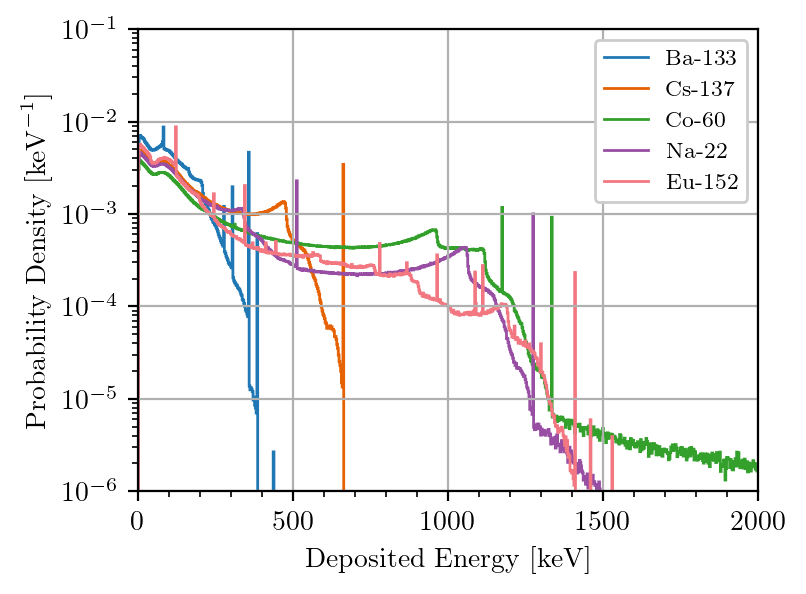

In [21]:
dir_gamma = 'data/gamma/'
files_gamma = ['spectrum_ba133_ene.root','spectrum_cs137_ene.root','spectrum_co60_ene.root','spectrum_na22_ene.root','spectrum_eu152_ene.root']
gammas = ['Ba-133','Cs-137','Co-60','Na-22','Eu-152']
for f,g in zip(files_gamma,gammas):
    root_file = ROOT.TFile.Open(f"{dir_gamma}{f}", "read")
    root_hist = root_file.Get("hEne")
    bins_ene =[]
    rates_ene = []
    for i in range(1,root_hist.GetNbinsX()+1):
        bins_ene.append(root_hist.GetBinLowEdge(i))
        rates_ene.append(root_hist.GetBinContent(i))
    bins_ene.append(bins_ene[-1]+root_hist.GetBinWidth(1))
    bins_ene = np.array(bins_ene)
    rates_ene = np.array(rates_ene)
    rates_ene /= np.sum(rates_ene)*root_hist.GetBinWidth(1)
    plt.stairs(rates_ene, bins_ene,label=g)
plt.legend(loc='upper right')
plt.yscale('log')
plt.ylabel(r'Probability Density [$\rm{keV}^{-1}$]')
plt.ylim(1e-6,1e-1)
plt.xlim(0,2000)
plt.xlabel('Deposited Energy [keV]')
plt.grid()
plt.minorticks_on()

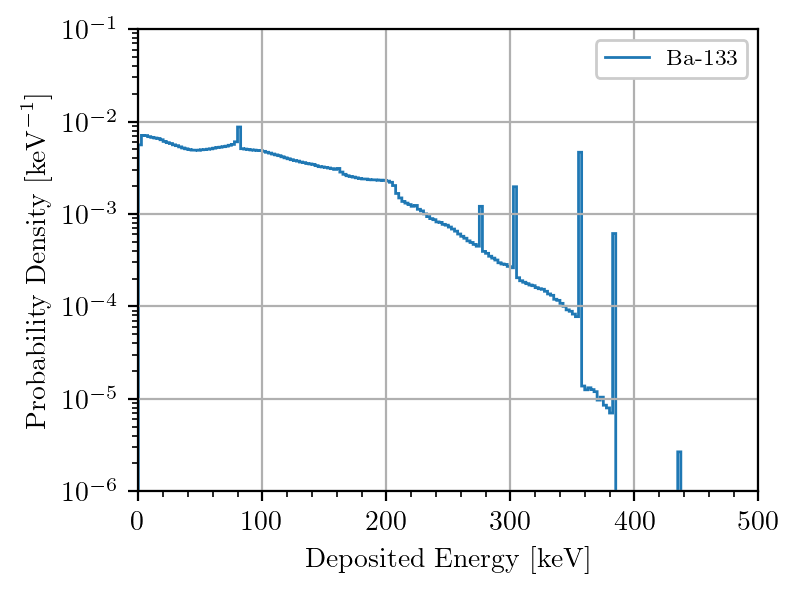

In [22]:
dir_gamma = 'data/gamma/'
files_gamma = ['spectrum_ba133_ene.root']
gammas = ['Ba-133']
for f,g in zip(files_gamma,gammas):
    root_file = ROOT.TFile.Open(f"{dir_gamma}{f}", "read")
    root_hist = root_file.Get("hEne")
    bins_ene =[]
    rates_ene = []
    for i in range(1,root_hist.GetNbinsX()+1):
        bins_ene.append(root_hist.GetBinLowEdge(i))
        rates_ene.append(root_hist.GetBinContent(i))
    bins_ene.append(bins_ene[-1]+root_hist.GetBinWidth(1))
    bins_ene = np.array(bins_ene)
    rates_ene = np.array(rates_ene)
    rates_ene /= np.sum(rates_ene)*root_hist.GetBinWidth(1)
    plt.stairs(rates_ene, bins_ene,label=g)
plt.legend(loc='upper right')
plt.yscale('log')
plt.ylabel(r'Probability Density [$\rm{keV}^{-1}$]')
plt.ylim(1e-6,1e-1)
plt.xlim(0,500)
plt.xlabel('Deposited Energy [keV]')
plt.grid()
plt.minorticks_on()

## Detector response model
Consider light yield non-uniformity. Let $\alpha$ be the relative RMS variation:
$$L'_y \sim \mathcal{N}(\mu = L_y, \sigma=\alpha L_y)$$
Fix Fano factor to $1+p$ derived from compound Poisson distribution. The $(1-p)^2$ factor is canceled out due to the DiCT correction in PE reconstruction.
This Fano factor accounts for photon transport and direct crosstalk effects.
$$N_{\rm PE} \sim \mathcal{N}(\mu=L'_y E_{\rm dep}, \sigma=\sqrt{(1+p)L'_y E_{\rm dep}})$$

In [23]:
import scipy.integrate as intg 
from scipy.stats import norm
import math

class Spectrum():
    def __init__(self, dict, root_file_path="data/gamma/spectrum_cs137_ene.root", pe_max=1500, pe_width=5):
        self.pe_max = pe_max
        self.pe_width = pe_width
        self.root_file_path = root_file_path
        self.bins_ene =[]
        self.rates_ene = []
        self.dict = dict
        self.ly = 0
        self.alpha = 0
        self.read_energy_spectrum()
    
    def read_energy_spectrum(self):
        self.root_file = ROOT.TFile.Open(self.root_file_path, "read")
        root_hist = self.root_file.Get("hEne")
        for i in range(1,root_hist.GetNbinsX()+1):
            self.bins_ene.append(root_hist.GetBinLowEdge(i))
            self.rates_ene.append(root_hist.GetBinContent(i))
        self.bins_ene.append(self.bins_ene[-1]+root_hist.GetBinWidth(1))
        self.bins_ene = np.array(self.bins_ene)
        self.rates_ene = np.array(self.rates_ene)
        self.rates_ene /= np.sum(self.rates_ene) # normalize total count to 1

    def response_matrix(self, ene, pe, ly):
        return norm.pdf(pe, loc=ly*ene, scale=np.sqrt(ly*ene*(1+self.dict)))

    def get_pe_spectrum(self, ly, alpha):
        self.ly = ly
        self.alpha = alpha
        # self.bins_pe = self.bins_ene*ly
        self.bins_pe = np.arange(0,self.pe_max, self.pe_width)
        self.rates_pe = np.zeros(self.bins_pe.shape[0]-1)
        bincen_ene = (self.bins_ene[1:] + self.bins_ene[:-1])/2
        bincen_pe = (self.bins_pe[1:] + self.bins_pe[:-1])/2
        bincen_ly = np.linspace(max(ly*(1-3*alpha),0), ly*(1+5*alpha), 100)
        ene_mesh, pe_mesh, ly_mesh = np.meshgrid( bincen_ene, bincen_pe, bincen_ly)
        s_ly = norm.pdf(bincen_ly,loc=ly, scale=ly*alpha)
        self.rates_pe = np.dot(np.dot(self.response_matrix(ene_mesh, pe_mesh, ly_mesh),s_ly),self.rates_ene)
        self.rates_pe *= (bincen_ly[1]-bincen_ly[0])
        
    def pe_spectrum(self, pe, ly, alpha, n):
        if not math.isclose(ly, self.ly) or not math.isclose(alpha, self.alpha):
            self.get_pe_spectrum(ly, alpha)
        pe_id = (np.clip(pe/(self.bins_pe[1]-self.bins_pe[0]),0, self.bins_pe.shape[0]-2)).astype(int)
        return n*self.rates_pe[pe_id]

## Read DiCT probability from h5 file

In [24]:
p_dict = {}
syserr2 = {}
for pos in positions:
    p_dict[pos] = {}
    syserr2[pos] = {}
    for volt in voltages:
        calib_df = pd.read_hdf('data/calibration_liq3.h5',key=f'/{pos}/{volt}V')
        p_dict[pos][volt] = np.mean(calib_df['DiCT'])
        syserr2[pos][volt] = np.mean((calib_df['Qpeak_err']/calib_df['Qpeak'])**2 + (calib_df['DiCT_err']/(1-calib_df['DiCT']))**2)
print('DiCT probability:')
print(p_dict)
print('Systematics from calibration:')
print(syserr2)

DiCT probability:
{'top': {67: 0.22261089170836224}, 'bottom': {67: 0.2378846507697942}}
Systematics from calibration:
{'top': {67: 4.5594437173258393e-05}, 'bottom': {67: 0.00015180516810782364}}


Text(0.5, 0, '$N_{\\rm PE}$')

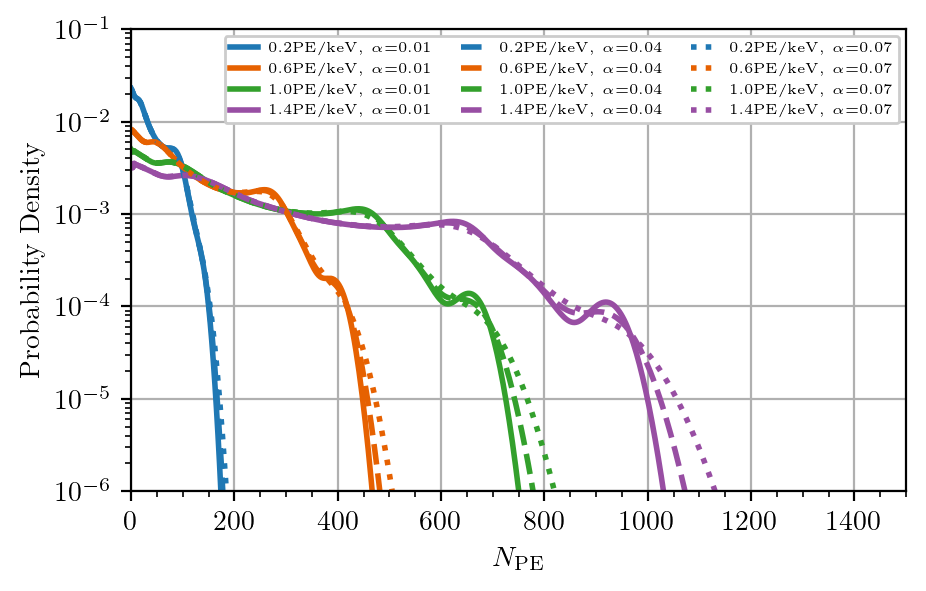

In [25]:
s = Spectrum(p_dict['top'][67], pe_max=1500, pe_width=3, root_file_path="data/gamma/spectrum_cs137_ene.root")
alphas = [0.01, 0.04, 0.07]
lys = [0.2, 0.6, 1.0, 1.4]
pe_arr = np.arange(0,1500,3)
styles = ['solid', 'dashed', 'dotted']
plt.figure(figsize=(5,3))
for i,a_ in enumerate(alphas):
    for j,l_ in enumerate(lys):
        s.get_pe_spectrum(l_, a_)
        pe_spectrum = s.pe_spectrum(pe_arr, l_, a_, 1.0)
        plt.plot(pe_arr, pe_spectrum,label=r'${}$PE/keV, $\alpha$={}'.format(l_,a_),color=f'C{j}',linestyle=styles[i])
plt.yscale('log')
plt.ylim(1e-6,1e-1)
plt.xlim(0,1500)
plt.grid()
plt.minorticks_on()
plt.legend(loc='upper right',ncol=3,prop={'size': 5})
plt.ylabel('Probability Density')
plt.xlabel(r'$N_{\rm PE}$')

# Compare with MC spectra + response model

Text(0.07, 0.5, 'Probability Density per PE')

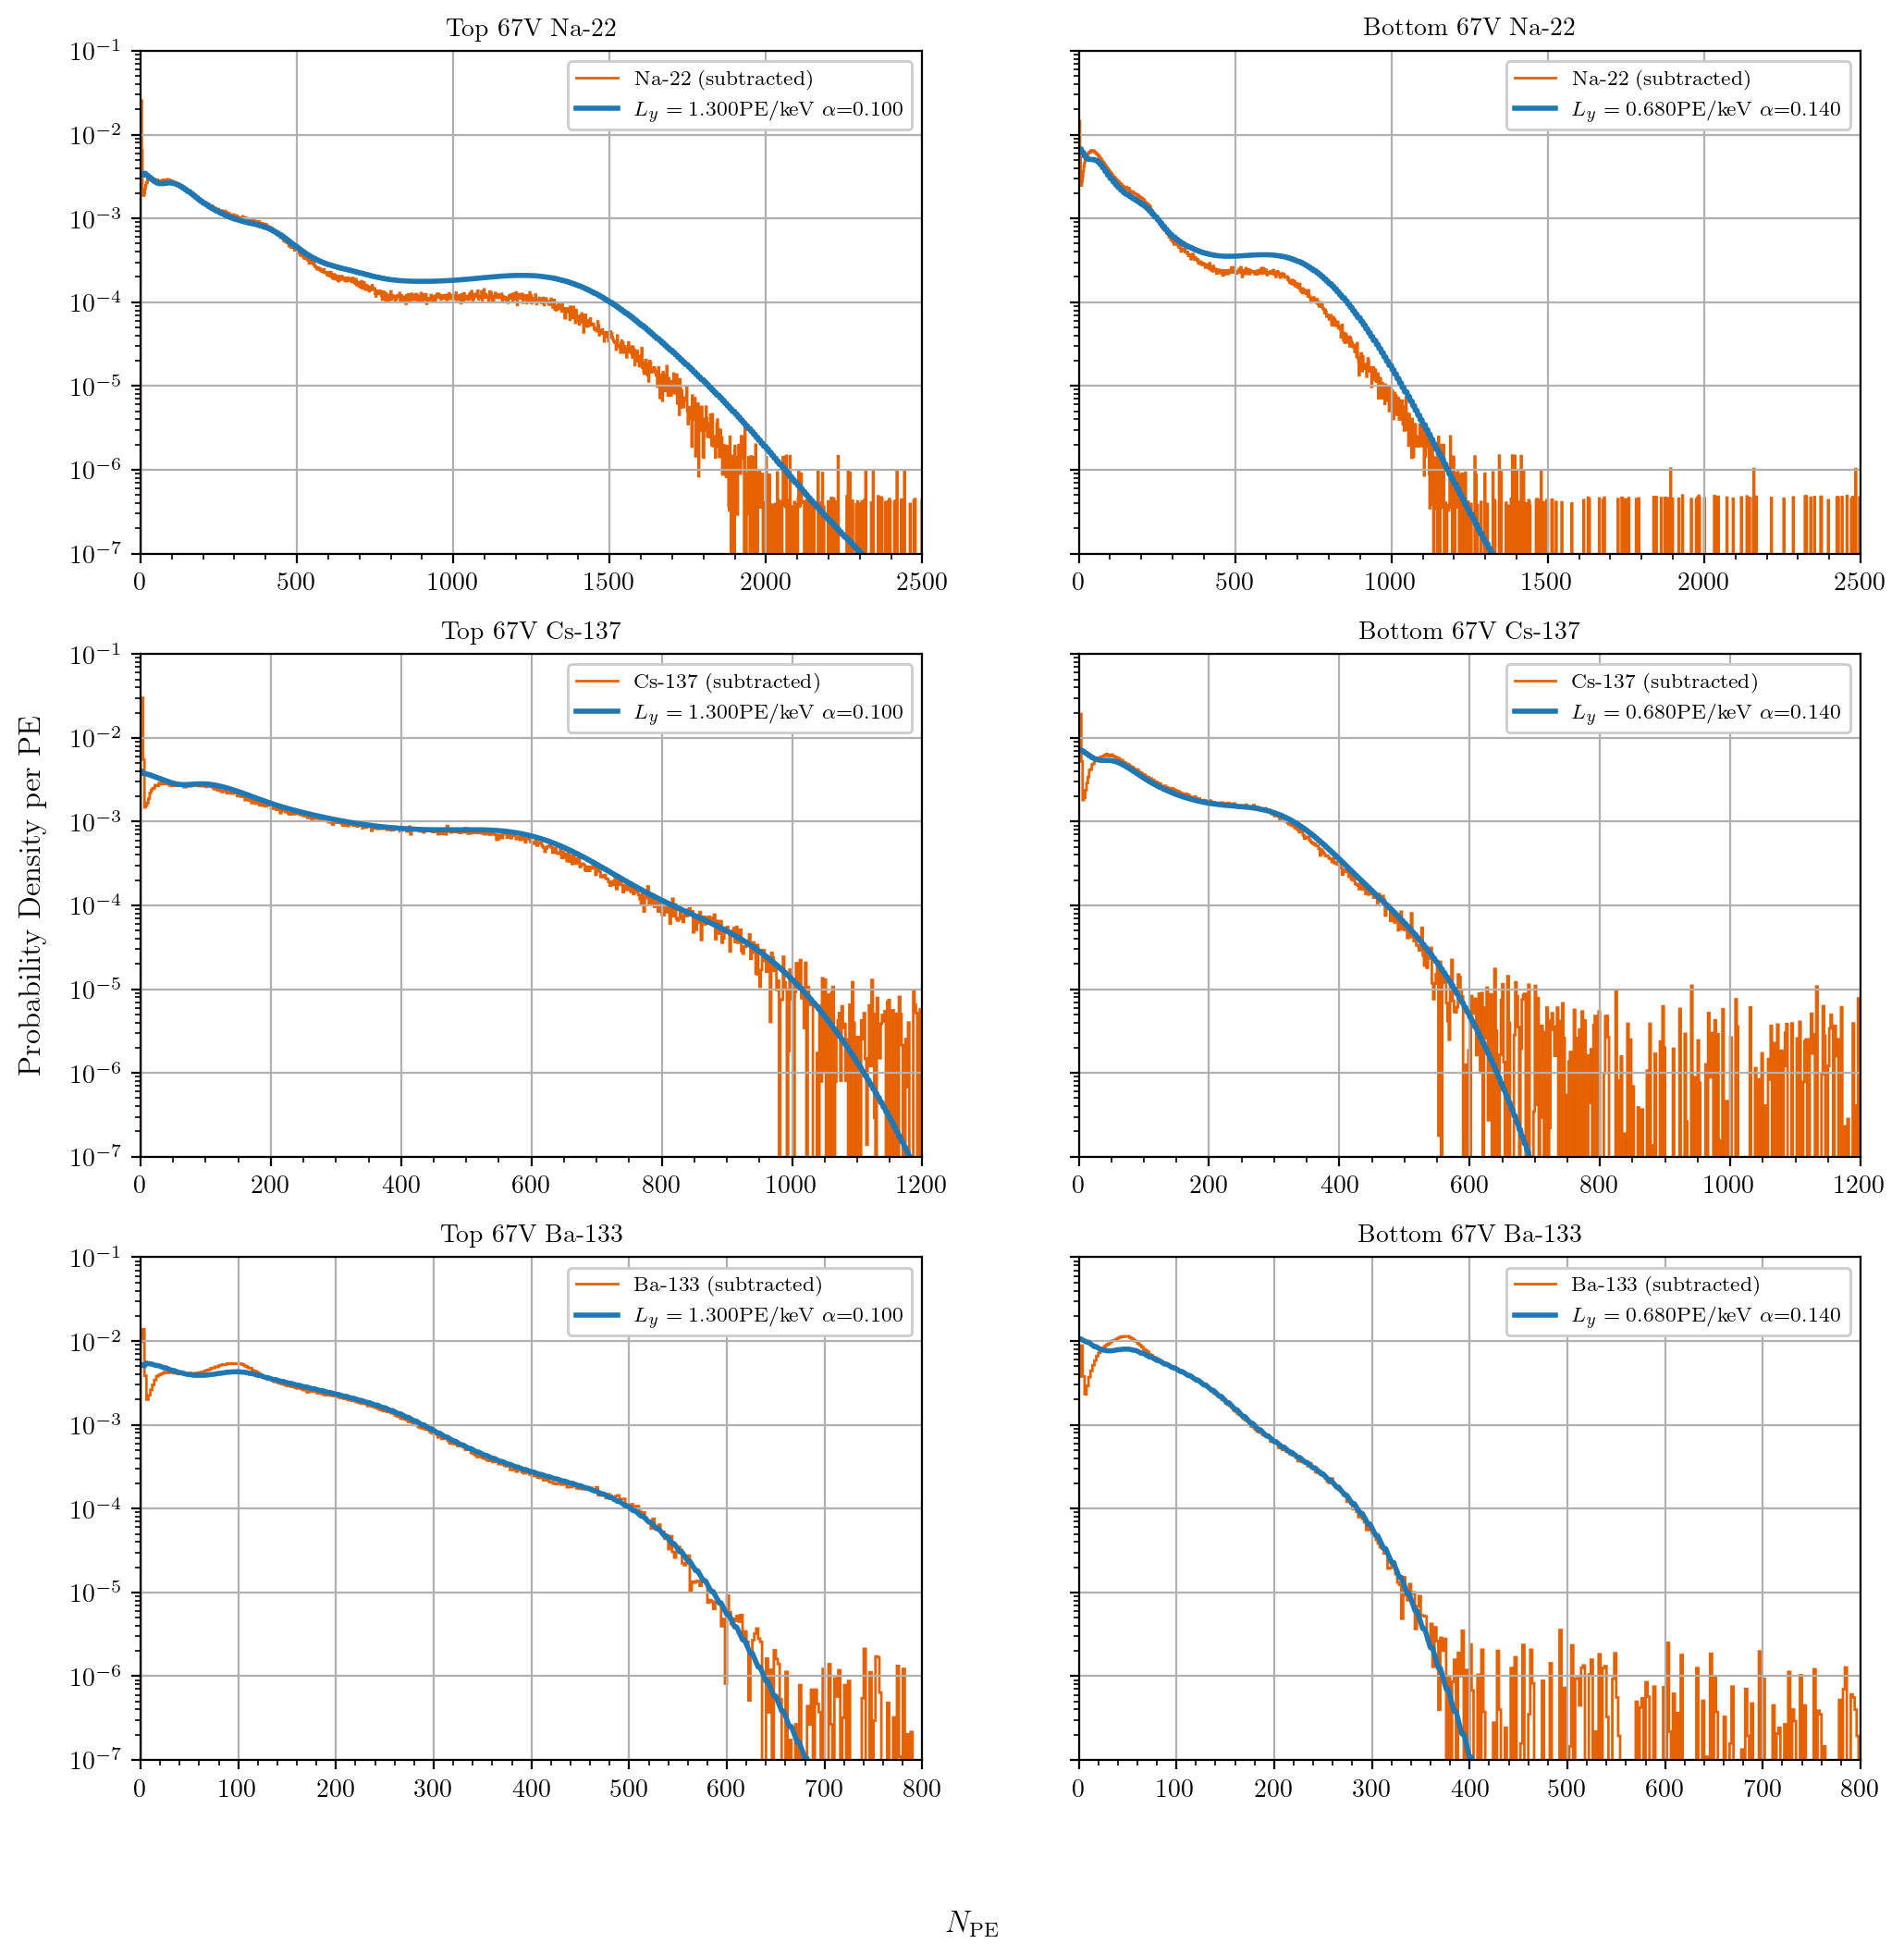

In [26]:
# Make plots for all datasets
# With source, without source, and background subtracted
fig, axs = plt.subplots(3, 2, sharex=False, sharey=True)
fig.set_size_inches(12, 12)
light_yield = {'top':1.3, 'bottom':0.68}
alpha = {'top':0.1, 'bottom':0.14}
max_pe = {'Na-22':2500, 'Cs-137':1200, 'Ba-133':800}
files = {'Na-22':'spectrum_na22_ene.root', 'Cs-137':'spectrum_cs137_ene.root', 'Ba-133':'spectrum_ba133_ene.root'}
for i, pos in enumerate(positions):
    for j, volt in enumerate(voltages):
        for k, t in enumerate(types[-3:]):
            integral = np.sum(spectra[t][pos][volt]['counts'])
            bin_width = spectra[t][pos][volt]['bins'][1]-spectra[t][pos][volt]['bins'][0]
            axs[k, i].stairs(
                spectra[t][pos][volt]['counts']/integral/bin_width,
                spectra[t][pos][volt]['bins'],
                label=f'{t}', color=f'C1'
            )
            model = Spectrum(p_dict[pos][67], pe_max=max_pe[types[k+1]]*1.2, pe_width=max_pe[types[k+1]]/300, root_file_path=f"data/gamma/{files[types[k+1]]}")
            axs[k, i].plot(
                spectra[t][pos][volt]['bins'],
                model.pe_spectrum(spectra[t][pos][volt]['bins'], light_yield[pos], alpha[pos], 1), 
                label=r'$L_y={:.3f}$PE/keV $\alpha$={:.3f}'.format(light_yield[pos], alpha[pos])
            )
            axs[k, i].legend(loc='upper right')
            axs[k, i].set_ylim(1e-7, 1e-1)
            axs[k, i].set_xlim(spectra[t][pos][volt]['bins'][0],max_pe[types[k+1]])
            axs[k, i].set_yscale('log')
            axs[k, i].minorticks_on()
            axs[k, i].grid()
            axs[k, i].set_title(f'{pos[0].upper()}{pos[1:]} {volt}V {types[k+1]}')
fig.supxlabel(r'$N_{\rm PE}$', y=0.03)
fig.supylabel('Probability Density per PE', x=0.07)

## Fit

In [27]:
# Initialize container
spectrum_fit = {}
sources = ['Cs-137', 'Ba-133']
for pos in positions:
    spectrum_fit[pos] = {}
    for s in sources:
        spectrum_fit[pos][s] = {}

In [28]:
ly_guess = {'top':[1.3,1.3], 'bottom':[0.62,0.62]}
fit_min = {'top':[200,200], 'bottom':[100,100]}
fit_max = {'top':[1000,600], 'bottom':[550,360]}
files = ['data/gamma/spectrum_cs137_ene.root','data/gamma/spectrum_ba133_ene.root']
analytic_spectra = {'top':[], 'bottom':[]}
volt = 67
for pos in positions:
    for i,s in enumerate(sources):
        print(f'Running for {pos} {s}')
        # Spectrum fit range
        spectrum_fit[pos][s]['fit_range'] = [fit_min[pos][i], fit_max[pos][i]]
        spectrum_fit[pos][s]['data'] = {
            'bins':spectra[s+' (subtracted)'][pos][volt]['bins'],
            'x':0.5*(spectra[s+' (subtracted)'][pos][volt]['bins'][1:]+spectra[s+' (subtracted)'][pos][volt]['bins'][:-1]), 
            'y':spectra[s+' (subtracted)'][pos][volt]['counts'], 
            'yerr':spectra[s+' (subtracted)'][pos][volt]['errs']
        }
        spec = Spectrum(dict=p_dict[pos][volt],pe_max=spectrum_fit[pos][s]['fit_range'][1]*1.5, pe_width=spectrum_fit[pos][s]['fit_range'][1]/500, root_file_path=files[i])
        analytic_spectra[pos].append(spec)
        in_fit_range = (spectrum_fit[pos][s]['data']['x']>spectrum_fit[pos][s]['fit_range'][0])&(spectrum_fit[pos][s]['data']['x']<spectrum_fit[pos][s]['fit_range'][1])
        spectrum_fit[pos][s]['pars'], spectrum_fit[pos][s]['cov'] = curve_fit(
            spec.pe_spectrum, 
            spectrum_fit[pos][s]['data']['x'][in_fit_range],
            spectrum_fit[pos][s]['data']['y'][in_fit_range],
            p0=[ly_guess[pos][i], 0.1, np.sum(spectrum_fit[pos][s]['data']['y'])],
            sigma=spectrum_fit[pos][s]['data']['yerr'][in_fit_range],
            maxfev=10000)
        # spectrum_fit[pos][s]['chi2'] = {'x': X, 'y':Y, 'z':chi2map}
        spectrum_fit[pos][s]['chi2'] = np.sum(((spectrum_fit[pos][s]['data']['y'][in_fit_range]-spec.pe_spectrum(spectrum_fit[pos][s]['data']['x'][in_fit_range],*spectrum_fit[pos][s]['pars'])) / spectrum_fit[pos][s]['data']['yerr'][in_fit_range]) ** 2)
        spectrum_fit[pos][s]['dof'] = np.sum(in_fit_range)-3
        print(f'chi2={spectrum_fit[pos][s]["chi2"]} dof={spectrum_fit[pos][s]["dof"]}')

        # Print best fit values and 68% CL
        ly_fit = spectrum_fit[pos][s]['pars'][0]
        alpha_fit = spectrum_fit[pos][s]['pars'][1]
        ly_68 = func.error_distance(df=3,sigma=1)*np.sqrt(spectrum_fit[pos][s]['cov'][0,0])
        alpha_68 = func.error_distance(df=3,sigma=1)*np.sqrt(spectrum_fit[pos][s]['cov'][1,1])
        print('Ly={:.3f}+/-{:.3f} PE/keV  alpha={:.3f}+/-{:.3f} (68% CL)'.format(ly_fit, ly_68, alpha_fit, alpha_68))
        spectrum_fit[pos][s]['ly'] = ly_fit
        spectrum_fit[pos][s]['ly_err'] = ly_68
        spectrum_fit[pos][s]['alpha'] = alpha_fit
        spectrum_fit[pos][s]['alpha_err'] = alpha_68

Running for top Cs-137


chi2=482.3915278700064 dof=397
Ly=1.264+/-0.004 PE/keV  alpha=0.115+/-0.005 (68% CL)
Running for top Ba-133
chi2=236.91962323496102 dof=197
Ly=1.314+/-0.004 PE/keV  alpha=0.084+/-0.004 (68% CL)
Running for bottom Cs-137
chi2=343.6060301777825 dof=222
Ly=0.645+/-0.003 PE/keV  alpha=0.168+/-0.006 (68% CL)
Running for bottom Ba-133
chi2=165.83683244479295 dof=127
Ly=0.668+/-0.004 PE/keV  alpha=0.143+/-0.007 (68% CL)


Text(0.02, 0.5, 'Rate [A.U.]')

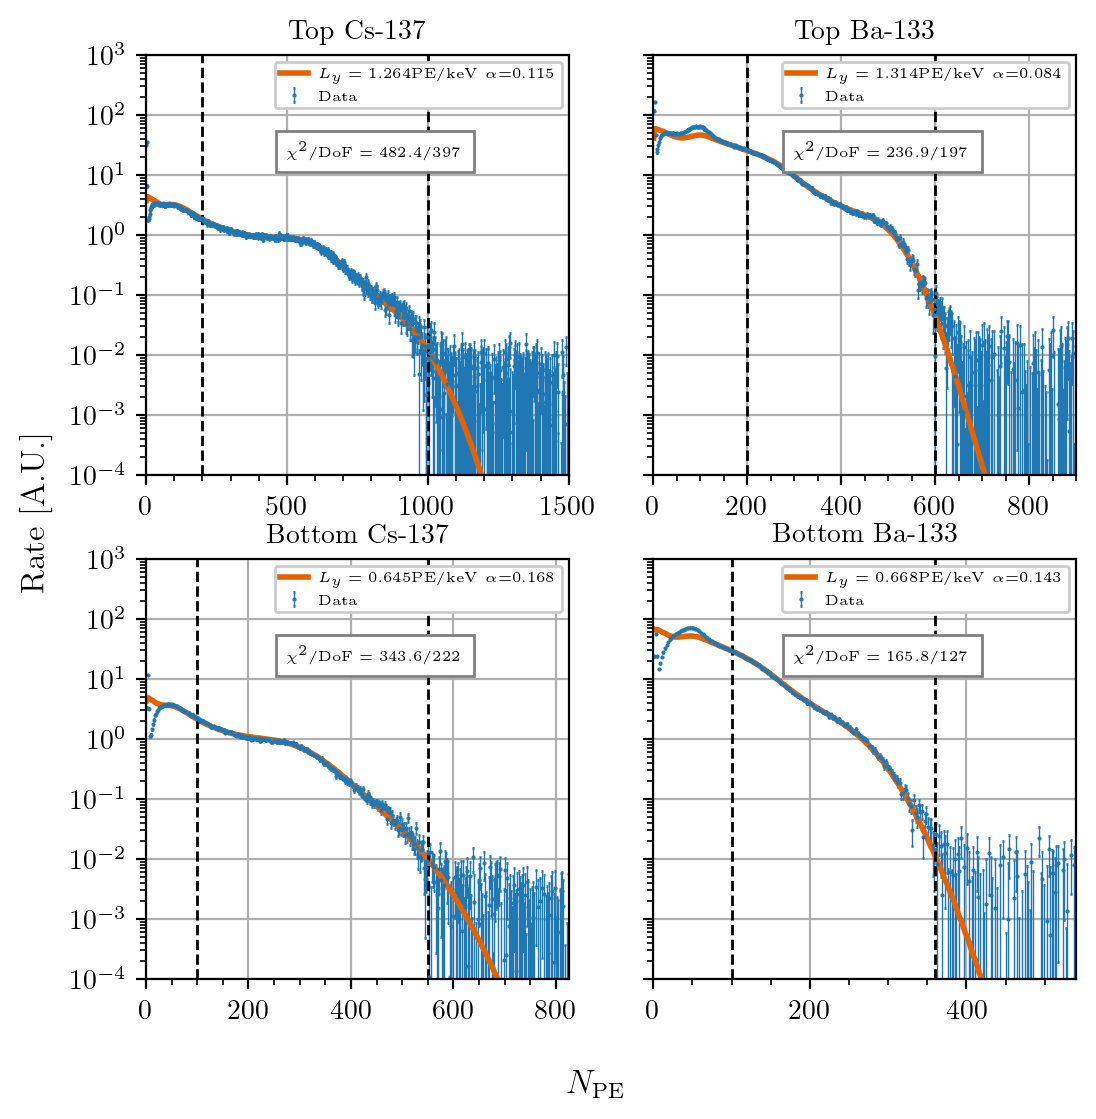

In [29]:
# Make plots for all datasets
# Fitted spectra
fig, axs = plt.subplots(2, 2, sharex=False, sharey=True)
fig.set_size_inches(6, 6)
ymin = 1e-4
ymax = 1e3
for i,pos in enumerate(positions):
    for j,s in enumerate(sources):
        axs[i,j].errorbar(
            spectrum_fit[pos][s]['data']['x'],
            spectrum_fit[pos][s]['data']['y'],
            yerr=spectrum_fit[pos][s]['data']['yerr'],
            fmt='o', label='Data', ls='none', capsize=0.5, elinewidth=0.5, markersize=0.5
        )
        axs[i,j].plot(
            spectrum_fit[pos][s]['data']['x'],
            analytic_spectra[pos][j].pe_spectrum(spectrum_fit[pos][s]['data']['x'], *spectrum_fit[pos][s]['pars']), 
            label=r'$L_y={:.3f}$PE/keV $\alpha$={:.3f}'.format(spectrum_fit[pos][s]['ly'], spectrum_fit[pos][s]['alpha'])
        )
        axs[i,j].plot([spectrum_fit[pos][s]['fit_range'][0]]*2, [ymin, ymax], 'k--', linewidth=1)
        axs[i,j].plot([spectrum_fit[pos][s]['fit_range'][1]]*2, [ymin, ymax], 'k--', linewidth=1)
        axs[i,j].text(
            spectrum_fit[pos][s]['fit_range'][1]*0.5, 
            ymax/50, 
            r'$\chi^2/\rm DoF={:.1f}/{:.0f}$'.format(spectrum_fit[pos][s]['chi2'],spectrum_fit[pos][s]['dof']), 
            fontsize=5,bbox=dict(facecolor='white',edgecolor='grey',alpha=1)
        )
        axs[i,j].grid()
        axs[i,j].minorticks_on()
        axs[i,j].set_yscale('log')
        axs[i,j].legend(loc='upper right', fontsize=5)
        axs[i,j].set_xlim(0, spectrum_fit[pos][s]['fit_range'][1]*1.5)
        axs[i,j].set_ylim(ymin, ymax)
        axs[i,j].set_title(f'{pos[0].upper()}{pos[1:]} {s}')
fig.supxlabel(r'$N_{\rm PE}$')
fig.supylabel('Rate [A.U.]')

Text(0, 0.5, 'Rate [A.U.]')

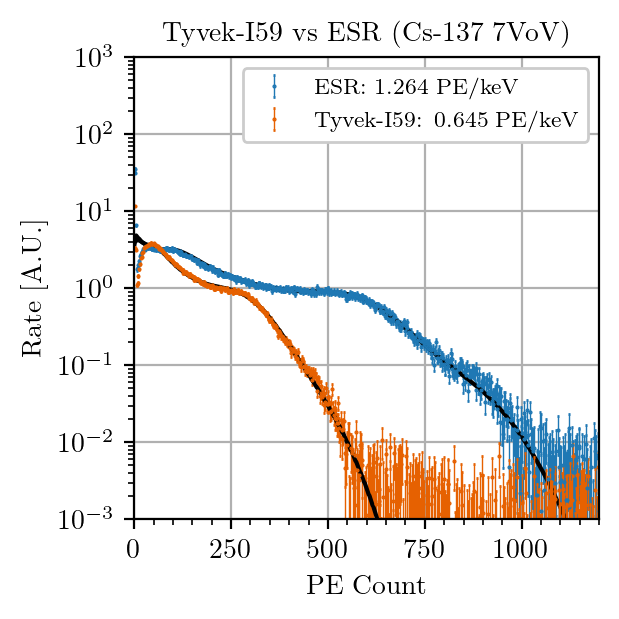

In [30]:
fig, axs = plt.subplots(1, 1, sharex=False, sharey=True)
fig.set_size_inches(3, 3)
ymin = 1e-3
ymax = 1e3
s = 'Cs-137'
j=0
for i,pos in enumerate(positions):
    if pos=='top':
        refl = 'ESR'
    else:
        refl = 'Tyvek-I59'
    axs.errorbar(
        spectrum_fit[pos][s]['data']['x'],
        spectrum_fit[pos][s]['data']['y'],
        yerr=spectrum_fit[pos][s]['data']['yerr'],
        fmt='o', label=f'{refl}: {spectrum_fit[pos][s]["ly"]:.3f} PE/keV', ls='none', capsize=0.5, elinewidth=0.5, markersize=0.5, color=f'C{i}'
    )
    axs.plot(
        spectrum_fit[pos][s]['data']['x'],
        analytic_spectra[pos][j].pe_spectrum(spectrum_fit[pos][s]['data']['x'], *spectrum_fit[pos][s]['pars']), 'k-',
        label='_nolegend_',  linewidth=1.5
    )
axs.grid()
axs.minorticks_on()
axs.set_yscale('log')
axs.legend(loc='upper right', fontsize=8)
axs.set_xlim(0, 1200)
axs.set_ylim(ymin, ymax)
axs.set_title(f'Tyvek-I59 vs ESR (Cs-137 7VoV)')
axs.set_xlabel('PE Count')
axs.set_ylabel('Rate [A.U.]')

Text(0, 0.5, 'Rate [A.U.]')

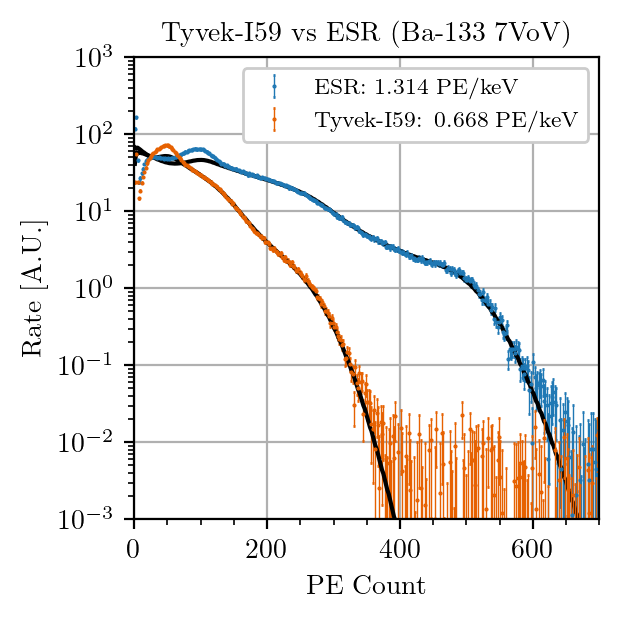

In [31]:
fig, axs = plt.subplots(1, 1, sharex=False, sharey=True)
fig.set_size_inches(3, 3)
ymin = 1e-3
ymax = 1e3
s = 'Ba-133'
j=1
for i,pos in enumerate(positions):
    if pos=='top':
        refl = 'ESR'
    else:
        refl = 'Tyvek-I59'
    axs.errorbar(
        spectrum_fit[pos][s]['data']['x'],
        spectrum_fit[pos][s]['data']['y'],
        yerr=spectrum_fit[pos][s]['data']['yerr'],
        fmt='o', label=f'{refl}: {spectrum_fit[pos][s]["ly"]:.3f} PE/keV', ls='none', capsize=0.5, elinewidth=0.5, markersize=0.5, color=f'C{i}'
    )
    axs.plot(
        spectrum_fit[pos][s]['data']['x'],
        analytic_spectra[pos][j].pe_spectrum(spectrum_fit[pos][s]['data']['x'], *spectrum_fit[pos][s]['pars']), 'k-',
        label='_nolegend_',  linewidth=1.5
    )
axs.grid()
axs.minorticks_on()
axs.set_yscale('log')
axs.legend(loc='upper right', fontsize=8)
axs.set_xlim(0, 700)
axs.set_ylim(ymin, ymax)
axs.set_title(f'Tyvek-I59 vs ESR (Ba-133 7VoV)')
axs.set_xlabel('PE Count')
axs.set_ylabel('Rate [A.U.]')

## Top-Bottom Comparison
The error bars for light yield (ratio) here include the contribution from calibration (SPE gain and DiCT probability)

In [32]:
# Initialize container
results = {
    'ly':{
        'ESR':{},'Tyvek':{}
    }, 
    'alpha':{
        'ESR':{},'Tyvek':{}
    },
    'ly_ratio':{
        'theory':{}, 'experiment':{}    
    }
}

Average Tyvek-to-ESR Ly ratio = 0.5092+/-0.0108(stat)+/-0.0013(sys)


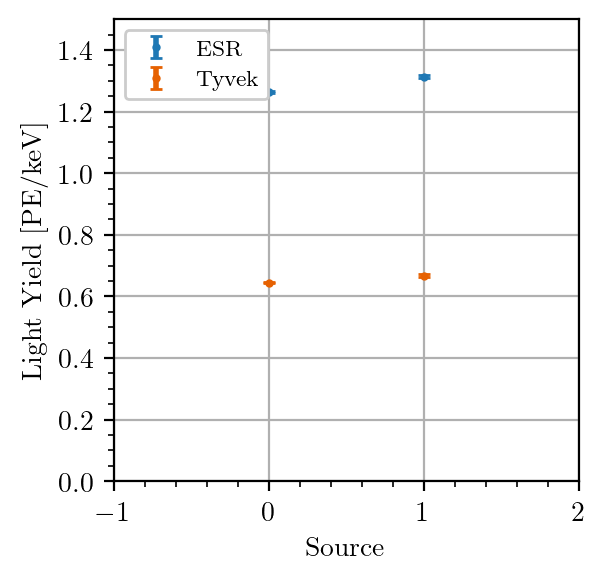

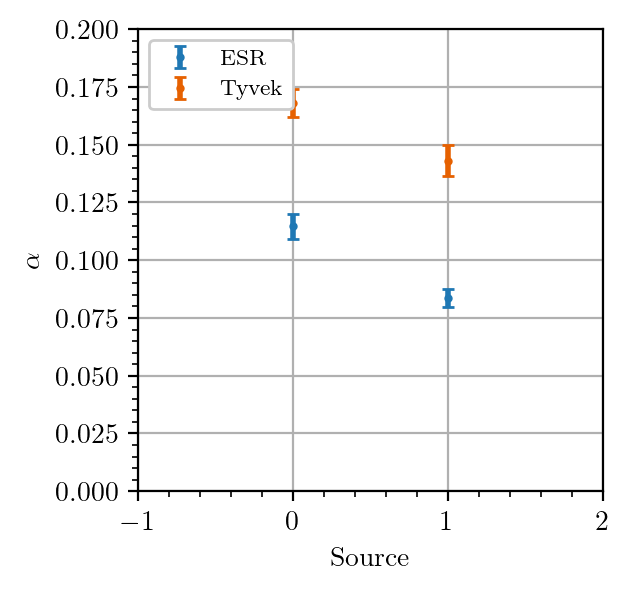

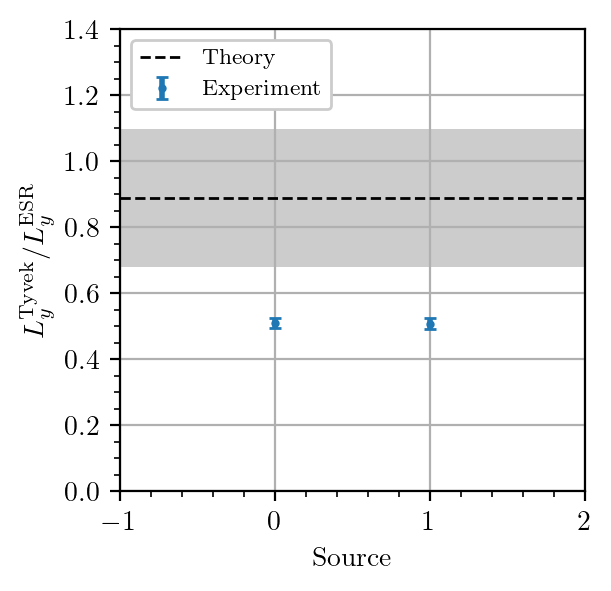

In [33]:
ly_ratio_th = 0.890
ly_ratio_th_err = 0.209
volt=67

for k1 in list(results.keys()):
    for k2,pos in zip(list(results[k1].keys()),positions):
        if k1=='ly' or k1=='alpha':
            results[k1][k2]['x'] = np.array([0,1])
            results[k1][k2]['y'] = np.array([spectrum_fit[pos][s][k1] for s in sources])
            results[k1][k2]['yerr'] = np.array([spectrum_fit[pos][s][k1+'_err'] for s in sources])
        elif k1=='ly_ratio':
            if k2=='theory':
                results[k1][k2]['x'] = np.array([-1, 2])
                results[k1][k2]['y'] = np.array([ly_ratio_th]*2)
                results[k1][k2]['yerr'] = np.array([ly_ratio_th_err]*2)
            elif k2=='experiment':
                results[k1][k2]['x'] = np.array([0, 1])
                results[k1][k2]['y'] = np.array([spectrum_fit['bottom'][s]['ly']/spectrum_fit['top'][s]['ly'] for s in sources])
                results[k1][k2]['yerr'] = np.array([
                (  
                    (spectrum_fit['top'][s]['ly_err']/spectrum_fit['top'][s]['ly'])**2 + 
                    syserr2['top'][volt] + 
                    (spectrum_fit['bottom'][s]['ly_err']/spectrum_fit['bottom'][s]['ly'])**2 + 
                    syserr2['bottom'][volt]
                )**0.5 for s in sources
                ])

plt.figure(1,figsize=(3,3))
labels = {'top':'ESR','bottom':'Tyvek'}
for ref in list(results['ly'].keys()):   
    plt.errorbar(
        results['ly'][ref]['x'],
        results['ly'][ref]['y'],
        yerr=results['ly'][ref]['yerr'], 
        fmt='o', label=ref, ls='none', elinewidth=2, capsize=2, markersize=2
    )
plt.xlabel('Source')
plt.ylabel(r'Light Yield [$\rm PE/keV$]')
plt.legend()
plt.grid()
plt.minorticks_on()
plt.xlim(-1,2)
plt.ylim(0,1.5)

plt.figure(2,figsize=(3,3))
for ref in list(results['alpha'].keys()):   
    plt.errorbar(
        results['alpha'][ref]['x'],
        results['alpha'][ref]['y'],
        yerr=results['alpha'][ref]['yerr'], 
        fmt='o', label=ref, ls='none', elinewidth=2, capsize=2, markersize=2
    )
plt.xlabel('Source')
plt.ylabel(r'$\alpha$')
plt.legend()
plt.grid()
plt.minorticks_on()
plt.xlim(-1,2)
plt.ylim(0,0.2)

plt.figure(3,figsize=(3,3))
plt.errorbar(
    results['ly_ratio']['experiment']['x'],
    results['ly_ratio']['experiment']['y'],
    yerr=results['ly_ratio']['experiment']['yerr'], 
    fmt='o', label='Experiment', ls='none', elinewidth=2, capsize=2, markersize=2
)
plt.fill_between(
    x=results['ly_ratio']['theory']['x'],
    y1=results['ly_ratio']['theory']['y']-results['ly_ratio']['theory']['yerr'], 
    y2=results['ly_ratio']['theory']['y']+results['ly_ratio']['theory']['yerr'],
    facecolor='k',alpha=0.2
)
plt.plot(
    results['ly_ratio']['theory']['x'], 
    results['ly_ratio']['theory']['y'], 
    'k--', label='Theory', linewidth=1
)
plt.xlabel('Source')
plt.ylabel(r'$L_{y}^{\rm Tyvek}/L_{y}^{\rm ESR}$')
plt.grid()
plt.minorticks_on()
plt.legend()
plt.xlim(-1,2)
plt.ylim(0,1.4)

# Weighted average and statistical uncertainty
lyr_mu = np.sum(results['ly_ratio']['experiment']['y']/results['ly_ratio']['experiment']['yerr']**2) \
    /np.sum(1/results['ly_ratio']['experiment']['yerr']**2)
lyr_sigma = 1/np.sqrt(np.sum(1/results['ly_ratio']['experiment']['yerr']**2))
# RMS variation -> "systematic" uncertainty
lyr_rms = np.std(results['ly_ratio']['experiment']['y'], ddof=1)
print(f'Average Tyvek-to-ESR Ly ratio = {lyr_mu:.4f}+/-{lyr_sigma:.4f}(stat)+/-{lyr_rms:.4f}(sys)')
